# Importing Libraries

In [128]:
import numpy as np
import pandas as pd
from pathlib import Path
import missingno as msno

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from ydata_profiling import ProfileReport
import os
from sklearn.model_selection import train_test_split
%matplotlib inline
import matplotlib.ticker
warnings.filterwarnings('ignore')

from scipy.stats import chi2_contingency


# Loading Data

In [2]:
cc_data_full_data = pd.read_csv('/Users/manraj/Documents/GitHub/Credit Card Approval Prediction/dataset/application_record.csv')
credit_status = pd.read_csv('/Users/manraj/Documents/GitHub/Credit Card Approval Prediction/dataset/credit_record.csv')

In [3]:
cc_data_full_data

ID CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  CNT_CHILDREN  \
0       5008804           M            Y               Y             0   
1       5008805           M            Y               Y             0   
2       5008806           M            Y               Y             0   
3       5008808           F            N               Y             0   
4       5008809           F            N               Y             0   
...         ...         ...          ...             ...           ...   
438552  6840104           M            N               Y             0   
438553  6840222           F            N               N             0   
438554  6841878           F            N               N             0   
438555  6842765           F            N               Y             0   
438556  6842885           F            N               Y             0   

        AMT_INCOME_TOTAL      NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
0               427500.0               Working               Higher education   
1               427500.0               Working               Higher education   
2               112500.0               Working  Secondary / secondary special   
3               270000.0  Commercial associate  Secondary / secondary special   
4               270000.0  Commercial associate  Secondary / secondary special   
...                  ...                   ...                            ...   
438552          135000.0             Pensioner  Secondary / secondary special   
438553          103500.0               Working  Secondary / secondary special   
438554           54000.0  Commercial associate               Higher education   
438555           72000.0             Pensioner  Secondary / secondary special   
438556          121500.0               Working  Secondary / secondary special   

          NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  DAYS_BIRTH  DAYS_EMPLOYED  \
0             Civil marriage   Rented apartment      -12005          -4542   
1             Civil marriage   Rented apartment      -12005          -4542   
2                    Married  House / apartment      -21474          -1134   
3       Single / not married  House / apartment      -19110          -3051   
4       Single / not married  House / apartment      -19110          -3051   
...                      ...                ...         ...            ...   
438552             Separated  House / apartment      -22717         365243   
438553  Single / not married  House / apartment      -15939          -3007   
438554  Single / not married       With parents       -8169           -372   
438555               Married  House / apartment      -21673         365243   
438556               Married  House / apartment      -18858          -1201   

        FLAG_MOBIL  FLAG_WORK_PHONE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  \
0                1                1           0           0             NaN   
1                1                1           0           0             NaN   
2                1                0           0           0  Security staff   
3                1                0           1           1     Sales staff   
4                1                0           1           1     Sales staff   
...            ...              ...         ...         ...             ...   
438552           1                0           0           0             NaN   
438553           1                0           0           0        Laborers   
438554           1                1           0           0     Sales staff   
438555           1                0           0           0             NaN   
438556           1                0           1           0     Sales staff   

        CNT_FAM_MEMBERS  
0                   2.0  
1                   2.0  
2                   2.0  
3                   1.0  
4                   1.0  
...                 ...  
438552              1.0  
438553              1.0  
438554              1.0  
43855

In [4]:
cc_data_full_data['ID'].nunique()

438510

In [5]:
credit_status

ID  MONTHS_BALANCE STATUS
0        5001711               0      X
1        5001711              -1      0
2        5001711              -2      0
3        5001711              -3      0
4        5001712               0      C
...          ...             ...    ...
1048570  5150487             -25      C
1048571  5150487             -26      C
1048572  5150487             -27      C
1048573  5150487             -28      C
1048574  5150487             -29      C

[1048575 rows x 3 columns]

In [6]:
credit_status['ID'].nunique()

45985

STATUS
- C: paid off that month 
- X: No loan for the month
- 0: 1-29 days past due 
- 1: 30-59 days past due 
- 2: 60-89 days overdue 
- 3: 90-119 days overdue 
- 4: 120-149 days overdue 
- 5: Overdue or bad debts, write-offs for more than 150 days 

In [7]:
credit_status['STATUS'].value_counts()

STATUS
C    442031
0    383120
X    209230
1     11090
5      1693
2       868
3       320
4       223
Name: count, dtype: int64

Creating target variable

In [8]:
begin_month=pd.DataFrame(credit_status.groupby(['ID'])['MONTHS_BALANCE'].agg(min))
begin_month=begin_month.rename(columns={'MONTHS_BALANCE':'Account age'})
cc_data_full_data=pd.merge(cc_data_full_data,begin_month,how='left',on='ID')

This creates a value to guage how risky is that client

In [9]:
credit_status['dep_value'] = None
credit_status['dep_value'][credit_status['STATUS'] =='2']='Yes'
credit_status['dep_value'][credit_status['STATUS'] =='3']='Yes'
credit_status['dep_value'][credit_status['STATUS'] =='4']='Yes'
credit_status['dep_value'][credit_status['STATUS'] =='5']='Yes'
cpunt=credit_status.groupby('ID').count()
cpunt['dep_value'][cpunt['dep_value'] > 0]='Yes'
cpunt['dep_value'][cpunt['dep_value'] == 0]='No'
cpunt = cpunt[['dep_value']]

In [10]:
cc_data_full_data = pd.merge(cc_data_full_data,cpunt,how='inner',on='ID')
cc_data_full_data['Is high risk']=cc_data_full_data['dep_value']
cc_data_full_data.loc[cc_data_full_data['Is high risk']=='Yes','Is high risk']=1
cc_data_full_data.loc[cc_data_full_data['Is high risk']=='No','Is high risk']=0
cc_data_full_data.drop('dep_value',axis=1,inplace=True)
pd.options.mode.chained_assignment = None # hide warning SettingWithCopyWarning

# Renaming Features

In [11]:
cc_data_full_data.rename(columns={
    'CODE_GENDER':'Gender',
    'FLAG_OWN_CAR':'Has a car',
    'FLAG_OWN_REALTY':'Has a property',
    'CNT_CHILDREN':'Children count',
    'AMT_INCOME_TOTAL':'Income',
    'NAME_INCOME_TYPE':'Employment status',
    'NAME_EDUCATION_TYPE':'Education level',
    'NAME_FAMILY_STATUS':'Marital status',
    'NAME_HOUSING_TYPE':'Dwelling',
    'DAYS_BIRTH':'Age',
    'DAYS_EMPLOYED': 'Employment length',
    'FLAG_MOBIL': 'Has a mobile phone',
    'FLAG_WORK_PHONE': 'Has a work phone',
    'FLAG_PHONE': 'Has a phone',
    'FLAG_EMAIL': 'Has an email',
    'OCCUPATION_TYPE': 'Job title',
    'CNT_FAM_MEMBERS': 'Family member count',
    'Account age': 'Account age'
    },inplace=True)

# Split the data into training and test sets, creating a copy of the datasets

In [12]:
def split_dataset(df, size):
    train, test = train_test_split(df, test_size = size, random_state=42)
    return train.reset_index(drop=True), test.reset_index(drop=True)

In [13]:
train, test = split_dataset(cc_data_full_data, 0.2)

In [14]:
train.to_csv('/Users/manraj/Documents/GitHub/Credit Card Approval Prediction/dataset/train.csv')
test.to_csv('/Users/manraj/Documents/GitHub/Credit Card Approval Prediction/dataset/test.csv')

In [15]:
train_copy = train.copy()
test_copy = test.copy()

# Data Exploration

In [16]:
profile_report = ProfileReport(train_copy, explorative= True)
profile_report_path = Path('data_profile/data.html')

profile_report_path.parent.mkdir(parents=True, exist_ok=True)

try:
    profile_report_path.resolve(strict=True)
except FileNotFoundError:
    profile_report.to_file(profile_report_path)

In [17]:
cc_data_full_data.head()

ID Gender Has a car Has a property  Children count    Income  \
0  5008804      M         Y              Y               0  427500.0   
1  5008805      M         Y              Y               0  427500.0   
2  5008806      M         Y              Y               0  112500.0   
3  5008808      F         N              Y               0  270000.0   
4  5008809      F         N              Y               0  270000.0   

      Employment status                Education level        Marital status  \
0               Working               Higher education        Civil marriage   
1               Working               Higher education        Civil marriage   
2               Working  Secondary / secondary special               Married   
3  Commercial associate  Secondary / secondary special  Single / not married   
4  Commercial associate  Secondary / secondary special  Single / not married   

            Dwelling    Age  Employment length  Has a mobile phone  \
0   Rented apartment -12005              -4542                   1   
1   Rented apartment -12005              -4542                   1   
2  House / apartment -21474              -1134                   1   
3  House / apartment -19110              -3051                   1   
4  House / apartment -19110              -3051                   1   

   Has a work phone  Has a phone  Has an email       Job title  \
0                 1            0             0             NaN   
1                 1            0             0             NaN   
2                 0            0             0  Security staff   
3                 0            1             1     Sales staff   
4                 0            1             1     Sales staff   

   Family member count  Account age Is high risk  
0                  2.0        -15.0            0  
1                  2.0        -14.0            0  
2                  2.0        -29.0            0  
3                  1.0         -4.0            0  
4                  1.0        -26.0            0

In [18]:
cc_data_full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36457 entries, 0 to 36456
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   36457 non-null  int64  
 1   Gender               36457 non-null  object 
 2   Has a car            36457 non-null  object 
 3   Has a property       36457 non-null  object 
 4   Children count       36457 non-null  int64  
 5   Income               36457 non-null  float64
 6   Employment status    36457 non-null  object 
 7   Education level      36457 non-null  object 
 8   Marital status       36457 non-null  object 
 9   Dwelling             36457 non-null  object 
 10  Age                  36457 non-null  int64  
 11  Employment length    36457 non-null  int64  
 12  Has a mobile phone   36457 non-null  int64  
 13  Has a work phone     36457 non-null  int64  
 14  Has a phone          36457 non-null  int64  
 15  Has an email         36457 non-null 

In [19]:
cc_data_full_data.describe()

ID  Children count        Income           Age  \
count  3.645700e+04    36457.000000  3.645700e+04  36457.000000   
mean   5.078227e+06        0.430315  1.866857e+05 -15975.173382   
std    4.187524e+04        0.742367  1.017892e+05   4200.549944   
min    5.008804e+06        0.000000  2.700000e+04 -25152.000000   
25%    5.042028e+06        0.000000  1.215000e+05 -19438.000000   
50%    5.074614e+06        0.000000  1.575000e+05 -15563.000000   
75%    5.115396e+06        1.000000  2.250000e+05 -12462.000000   
max    5.150487e+06       19.000000  1.575000e+06  -7489.000000   

       Employment length  Has a mobile phone  Has a work phone   Has a phone  \
count       36457.000000             36457.0      36457.000000  36457.000000   
mean        59262.935568                 1.0          0.225526      0.294813   
std        137651.334859                 0.0          0.417934      0.455965   
min        -15713.000000                 1.0          0.000000      0.000000   
25%         -3153.000000                 1.0          0.000000      0.000000   
50%         -1552.000000                 1.0          0.000000      0.000000   
75%          -408.000000                 1.0          0.000000      1.000000   
max        365243.000000                 1.0          1.000000      1.000000   

       Has an email  Family member count   Account age  
count  36457.000000         36457.000000  36457.000000  
mean       0.089722             2.198453    -26.164193  
std        0.285787             0.911686     16.501854  
min        0.000000             1.000000    -60.000000  
25%        0.000000             2.000000    -39.000000  
50%        0.000000             2.000000    -24.000000  
75%        0.000000             3.000000    -12.000000  
max        1.000000            20.000000      0.000000

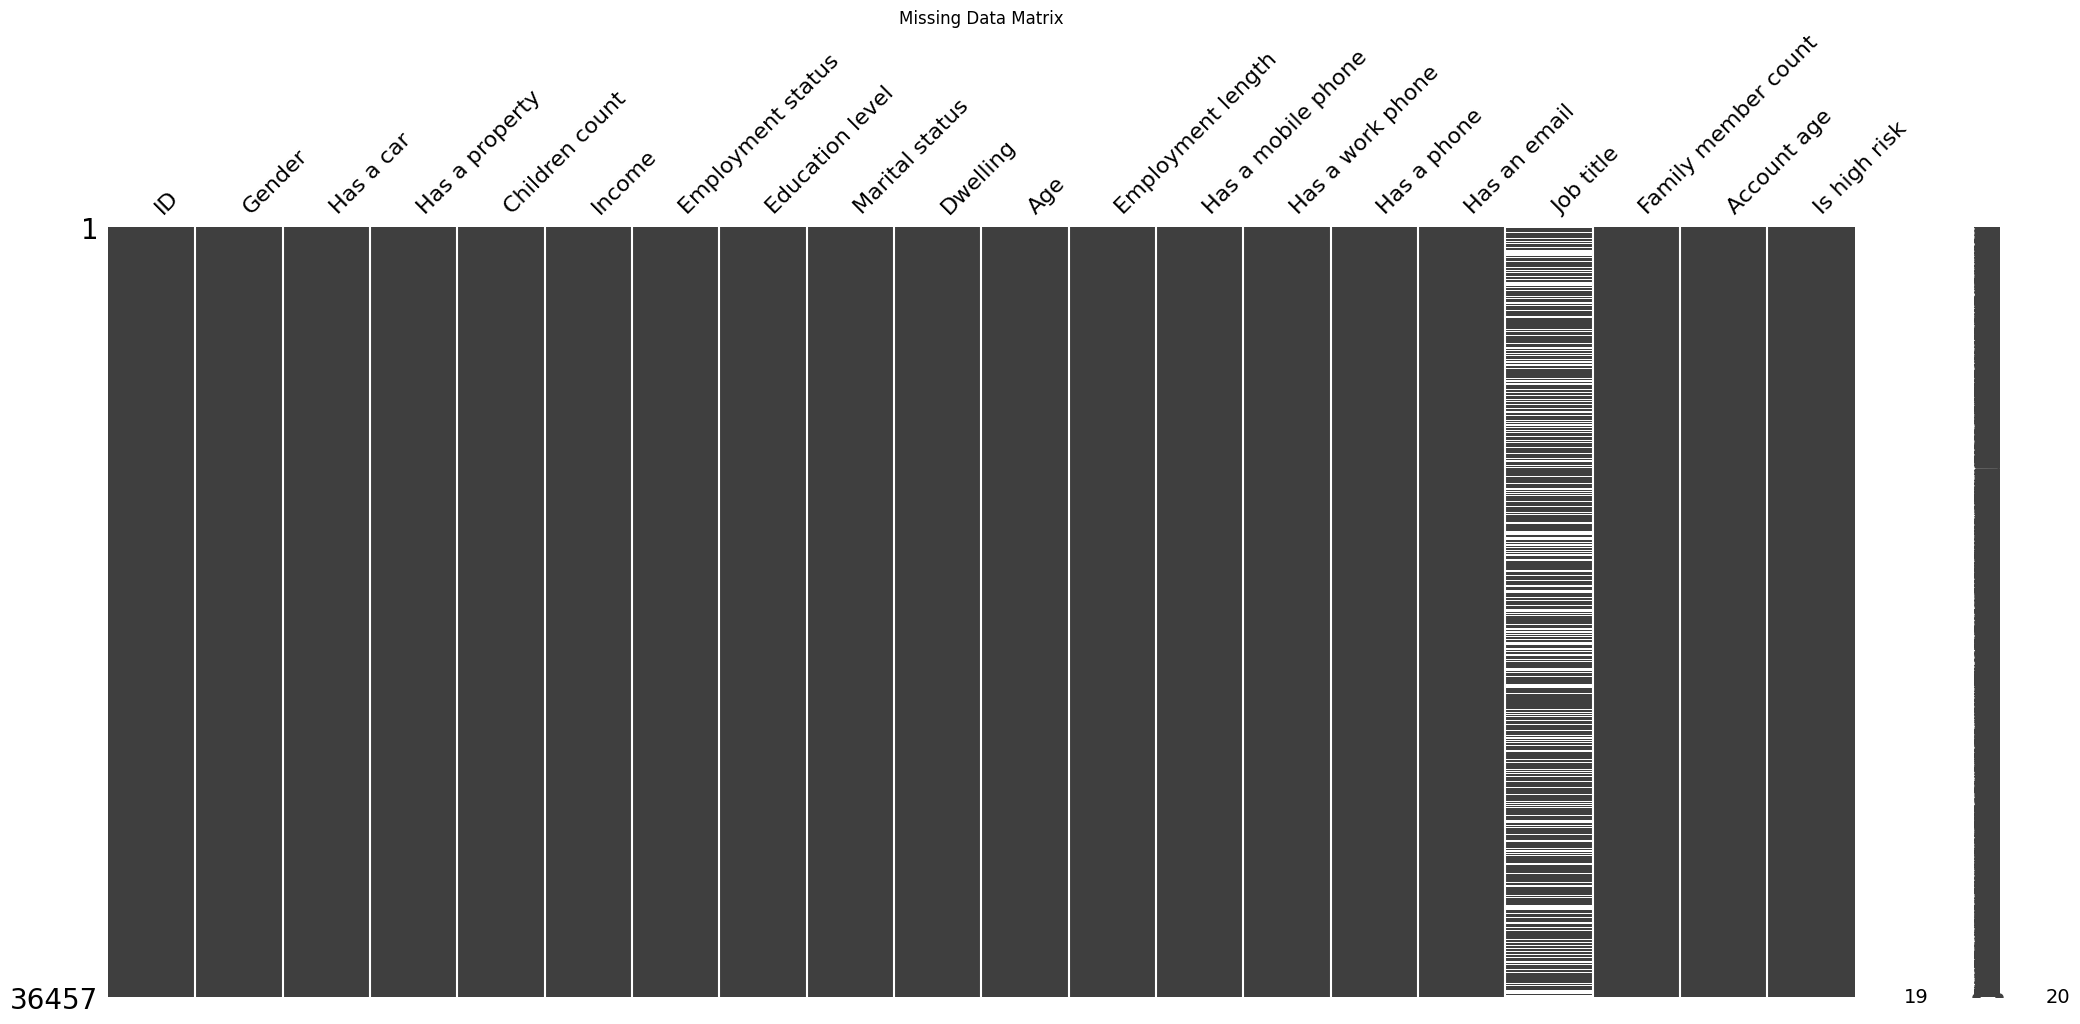

In [20]:
msno.matrix(cc_data_full_data)
plt.title("Missing Data Matrix")
plt.show()

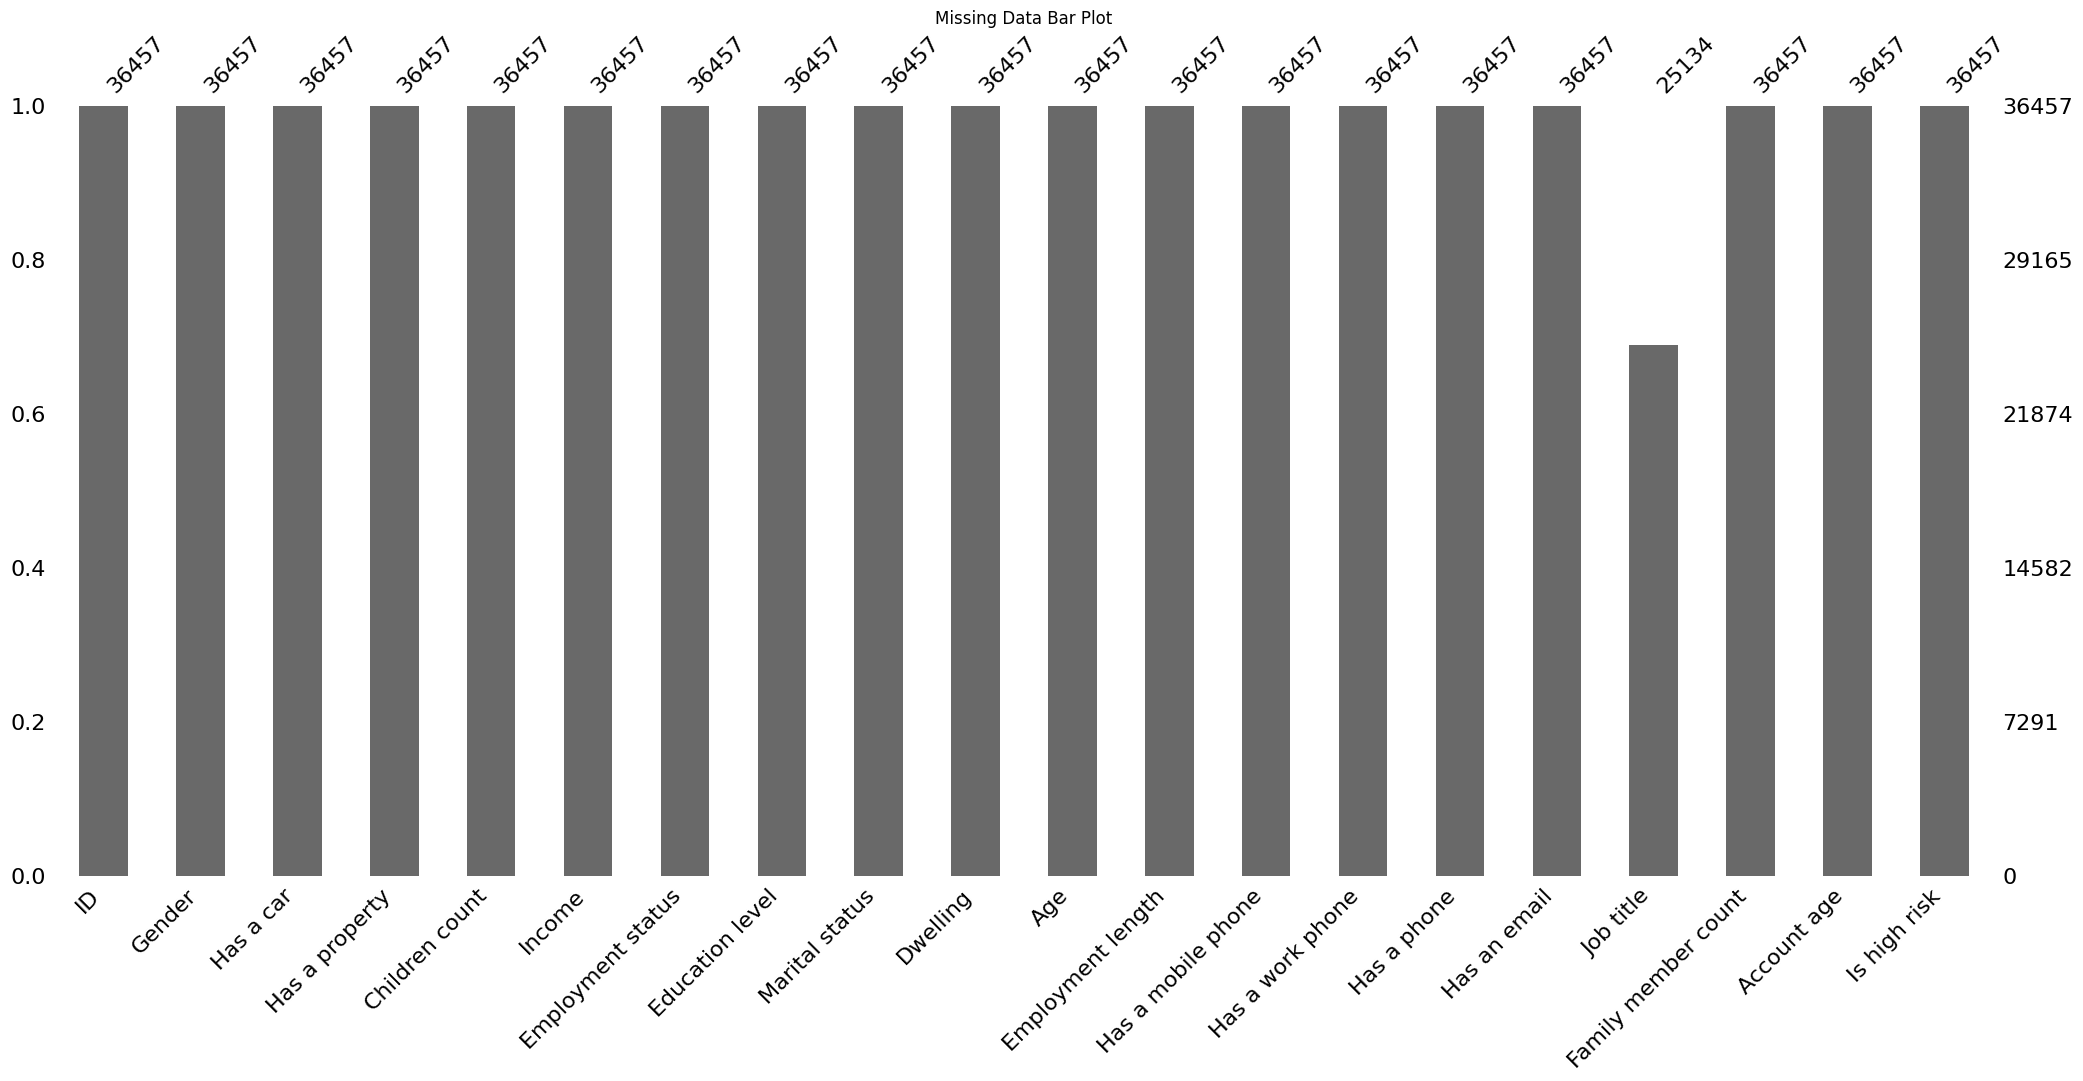

In [21]:
msno.bar(cc_data_full_data)
plt.title("Missing Data Bar Plot")
plt.show()

Funtions used to explore each feature

In [22]:
# function that will return the value count and frequency of each observation within a feature

def value_cnt_norm(df, feature):
    ftr_value_cnt = df[feature].value_counts()
    ftr_value_cnt_norm = df[feature].value_counts(normalize = True)*100
    ftr_value_cnt_concat = pd.concat([ftr_value_cnt, ftr_value_cnt_norm],axis=1)
    ftr_value_cnt_concat.columns = ['Count', 'Frequency (%)']
    return ftr_value_cnt_concat

In [23]:
# function to create display general information about the feature

def gen_info_feat(df, feature):
    match feature:
        case 'Age':
            print(f"Description: \n{((np.abs(df[feature])/365).describe())}")
            print("-"*50)
            print(f'Object type: \n{df[feature].dtype}')
        case 'Employment Length':
            emp_len = df['Employment length'].loc[df['Employment length']<0]
            emp_len_yrs = np.abs(emp_len)/365.25
            print(f"Description: \n{emp_len_yrs.describe()}")
            print("-"*50)
            print(f'Object type: \n{df[feature].dtype}')
        case 'Account age':
            print(f"Description: \n{(np.abs(df[feature]).describe())}")
            print("-"*50)
            print(f'Object type: \n{df[feature].dtype}')
        case _:
            print(f"Description: \n{(df[feature].describe())}")
            print("-"*50)
            print(f'Object type: \n{df[feature].dtype}')
            print("-"*50)
            val_cnt = value_cnt_norm(df,feature)
            print(f'Value count: \n{val_cnt}')


In [24]:
def pie_plot(df, feature):
    match feature:
        case 'Dwelling' | 'Education level':
            ratio_size = value_cnt_norm(df, feature)
            ratio_size_len = len(ratio_size.index)
            ratio_list = []
            for i in range(ratio_size_len):
                ratio_list.append(ratio_size.iloc[i]['Frequency (%)'])
            
            fig, ax = plt.subplots(figsize = (5,5))
            
            plt.pie(ratio_list, startangle=90, wedgeprops={'edgecolor' : 'black'})
            plt.title(f"Pie chart of {feature}")
            plt.legend(loc='best',labels = ratio_size.index)
            plt.axis('equal')
            return plt.show()
        case _:
            ratio_size = value_cnt_norm(df, feature)
            ratio_size_len = len(ratio_size.index)
            ratio_list = []
            for i in range(ratio_size_len):
                ratio_list.append(ratio_size.iloc[i]['Frequency (%)'])
            
            fig, ax = plt.subplots(figsize = (5,5))
            
            plt.pie(ratio_list, labels=ratio_size.index, autopct='%1.2f%%', startangle=90, wedgeprops={'edgecolor' : 'black'})
            plt.title(f"Pie chart of {feature}")
            plt.legend(loc='best',labels = ratio_size.index)
            plt.axis('equal')
            return plt.show()

In [25]:
def bar_plot(df, feature):
    match feature:
        case 'Marital status' | 'Dwelling' | 'Job title' | 'Employment status' | 'Education level':
            fig, ax = plt.subplots(figsize = (2,5))
            sns.barplot(x=value_cnt_norm(df, feature).index, y=value_cnt_norm(df, feature).values[:,0])
            ax.set_xticklabels(labels = value_cnt_norm(df, feature).index, rotation=45, ha='right')
            plt.xlabel(f"{feature}")
            plt.ylabel('Count')
            plt.title(f"{feature} count")
            return plt.show()
        case _:
            fig, ax = plt.subplots(figsize = (2,5))
            sns.barplot(x=value_cnt_norm(df,feature).index, y=value_cnt_norm(df,feature).values[:,0])
            plt.xlabel(f"{feature}")
            plt.ylabel('Count')
            plt.title(f"{feature} count")
            return plt.show()

In [26]:
def box_plot(df, feature):
    match feature:
        case 'Age':
            fig, ax = plt.subplots(figsize = (2, 5))
            sns.boxplot(y=np.abs(df[feature])/365.25)
            plt.title(f"{feature} boxplot")
            return plt.show()
        case 'Employment length':
            fig, ax = plt.subplots(figsize = (2, 5))
            emp_len_no_ret = df[feature].loc[df[feature]<0]
            emp_len_no_ret_yrs = np.abs(emp_len_no_ret)/365.25
            sns.boxplot(y=emp_len_no_ret_yrs)
            plt.title(f"{feature} boxplot")
            plt.yticks(np.arange(0,emp_len_no_ret_yrs.max(),2))
            return plt.show()
        case 'Income':
            fig, ax = plt.subplots(figsize = (2,5))
            sns.boxplot(y=df[feature])
            plt.title(f"{feature} boxplot")
            # supress scientific notation
            ax.get_yaxis().set_major_formatter(
                matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ','))
            )
            return plt.show()
        case 'Account age':
            fig, ax = plt.subplots(figsize = (2, 5))
            sns.boxplot(y=np.abs(df[feature]))
            plt.title(f"{feature} boxplot")
            return plt.show()
        case _:
            fig, ax = plt.subplots(figsize = (2, 5))
            sns.boxplot(y=np.abs(df[feature]))
            plt.title(f"{feature} boxplot")
            return plt.show()

In [27]:
def hist_plot(df, feature, bins= 50):
    match feature:
        case 'Age':
            fig, ax = plt.subplots(figsize=(8,5))
            # change the feature so it could be expressed in positive numbers
            sns.histplot(np.abs(df[feature])/365.25, bins=bins, kde=True)
            plt.title(f"{feature} distribution")
            return plt.show()
        case 'Income':
            fig, ax = plt.subplots(figsize = (8,5))
            sns.histplot(df[feature], bins=bins, kde=True)
            # supress scientific notaion
            ax.get_xaxis().set_major_formatter(
                matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ','))
            )
            plt.title(f"{feature} distribution")
        case 'Employment length':
            emp_len_no_ret = df[feature].loc[df[feature]<0]
            emp_len_no_ret_yrs = np.abs(emp_len_no_ret)/365.25
            fig, ax = plt.subplots(figsize = (8,5))
            sns.histplot(emp_len_no_ret_yrs, bins=bins, kde=True)
            plt.title(f"{feature} distribution")
            return plt.show()
        case 'Account age':
            fig, ax = plt.subplots(figsize = (8,5))
            sns.histplot(np.abs(df[feature]), bins=bins, kde=True)
            plt.title(f"{feature} boxplot")
            return plt.show()
        case _:
            fig, ax = plt.subplots(figsize=(18,10))
            sns.histplot(df[feature], bins=bins,kde=True)
            plt.title(f"{format} distribution")
            return plt.show()

In [28]:
def risk_box_plot(df, feature):
    match feature:
        case 'Age':
            print(np.abs(df.groupby('Is high risk')[feature].mean()/365.25))
            fig, ax = plt.subplots(figsize = (5,8))
            sns.boxplot(y=np.abs(df[feature])/365.25, x=df['Is high risk'])
            plt.xticks(ticks=[0,1], labels=['no','yes'])
            plt.title('High risk individuals grouped by age')
            return plt.show()
        case 'Income':
            print(np.abs(df.groupby('Is high risk')[feature].mean()))
            fig, ax = plt.subplots(figsize=(5,8))
            sns.boxplot(y=np.abs(df[feature]),x=df['Is high risk'])
            plt.xticks(ticks=[0,1],labels=['no','yes'])
            # supress scientif notaion
            ax.get_yaxis().set_major_formatter(
                matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ','))
            )
            plt.title(f'High risk individuals grouped by {feature}')
            return plt.show()
        case 'Employment length':
            emp_len_no_ret = df[feature].loc[df[feature]<0]
            emp_len_no_ret_idx = emp_len_no_ret.index
            emp_len_no_ret_yrs = np.abs(emp_len_no_ret)/365.25
            emp_no_ret_df = df.iloc[emp_len_no_ret_idx][['Employment length','Is high risk']]
            emp_no_ret_is_high_risk = emp_no_ret_df.groupby('Is high risk')['Employment length'].mean()
            print(np.abs(emp_no_ret_is_high_risk)/365.25)
            fig, ax = plt.subplots(figsize = (5,8))
            sns.boxplot(y=emp_len_no_ret_yrs, x=df['Is high risk'])
            plt.xticks(ticks=[0,1],labels=['no','yes'])
            plt.title(f"High vs low risk individuals grouped by {feature}")
            return plt.show()
        case _:
            print(np.abs(df.groupby('Is high risk')[feature].mean()))
            fig, ax = plt.subplots(figsize = (5,8))
            sns.boxplot(y=np.abs(df[feature]),x=df['Is high risk'])
            plt.xticks(ticks=[0,1], labels=['no', 'yes'])
            plt.title(f"High vs low risk individuals grouped by {feature}")
            return plt.show()            

In [29]:
# High risk vs low risk applicants compared on a bar plot
def risk_bar_plot(df,feature):
    is_high_risk_grp = df.groupby(feature)['Is high risk'].sum()
    is_high_risk_grp_srt = is_high_risk_grp.sort_values(ascending=False)
    print(dict(is_high_risk_grp_srt))
    fig, ax = plt.subplots(figsize=(6,10))
    sns.barplot(x=is_high_risk_grp_srt.index, y=is_high_risk_grp_srt.values)
    ax.set_xticklabels(labels=is_high_risk_grp_srt.index, rotation=45, ha='right')
    plt.ylabel("Count")
    plt.title(f"High risk applicants count grouped by {feature}")
    return plt.show()

# Univariate analysis

## Gender

In [30]:
gen_info_feat(train_copy,'Gender')

Description: 
count     29165
unique        2
top           F
freq      19549
Name: Gender, dtype: object
--------------------------------------------------
Object type: 
object
--------------------------------------------------
Value count: 
        Count  Frequency (%)
Gender                      
F       19549      67.028973
M        9616      32.971027


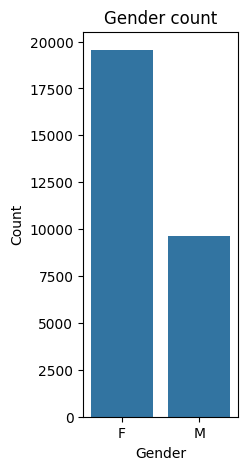

In [31]:
bar_plot(train_copy,'Gender')

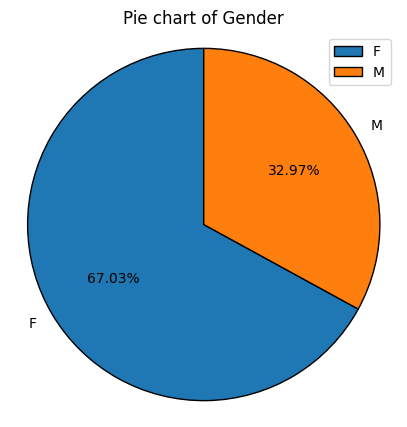

In [32]:
pie_plot(train_copy,'Gender')

### Interpretaion 
- There are more females applicants than male (67% vs 33%)

## Age

In [33]:
gen_info_feat(train_copy, 'Age')

Description: 
count    29165.000000
mean        43.779390
std         11.515062
min         21.109589
25%         34.178082
50%         42.643836
75%         53.271233
max         68.909589
Name: Age, dtype: float64
--------------------------------------------------
Object type: 
int64


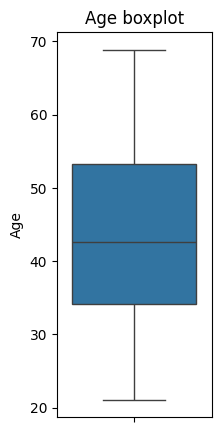

In [34]:
box_plot(train_copy,'Age')

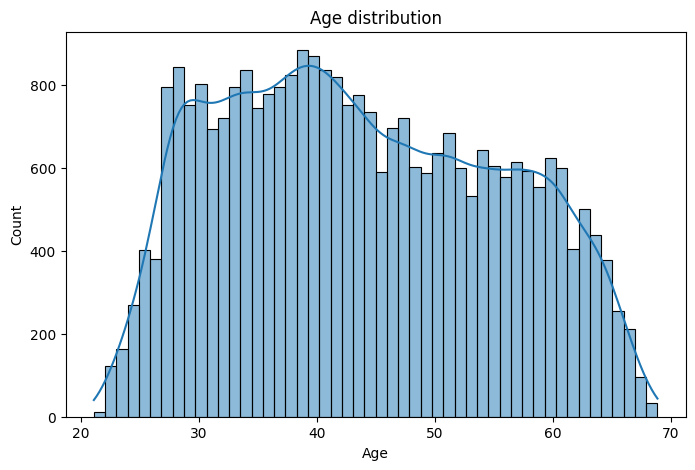

In [35]:
hist_plot(train_copy,'Age')

Is high risk
0    43.753103
1    43.538148
Name: Age, dtype: float64


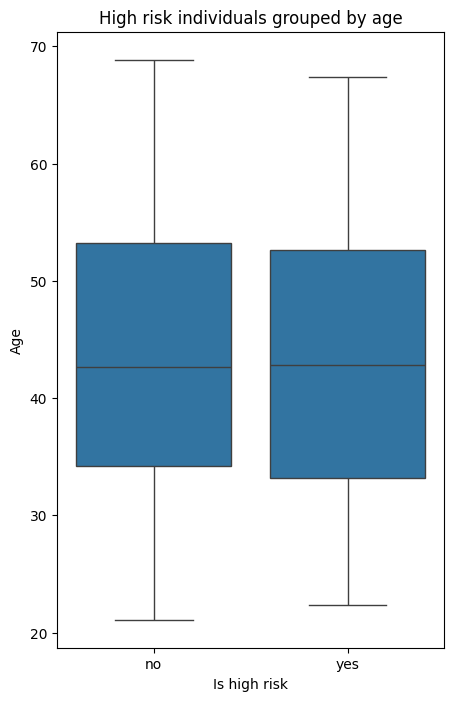

In [36]:
risk_box_plot(train_copy,'Age')

### Interpretaion 
- The youngest applicant is 21 years old whereas the oldest is 68 years old with the average if 43.7 and median of 42.6 (outlier insensitive)
- Age is not normally distributed it is slightly positively skew
- There is not difference between the average age of high and low risk applicants

## Marital status

In [37]:
gen_info_feat(train_copy, 'Marital status')

Description: 
count       29165
unique          5
top       Married
freq        20044
Name: Marital status, dtype: object
--------------------------------------------------
Object type: 
object
--------------------------------------------------
Value count: 
                      Count  Frequency (%)
Marital status                            
Married               20044      68.726213
Single / not married   3864      13.248757
Civil marriage         2312       7.927310
Separated              1712       5.870050
Widow                  1233       4.227670


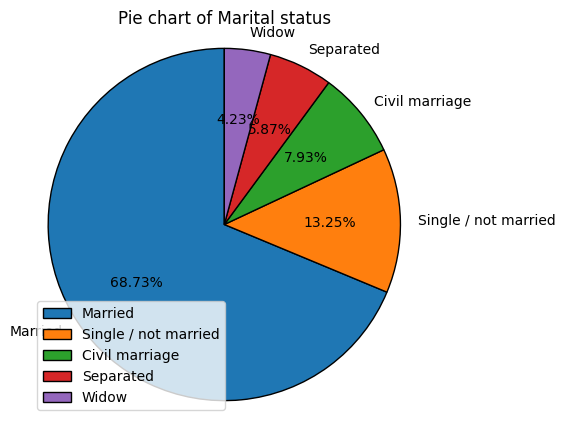

In [38]:
pie_plot(train_copy, 'Marital status')

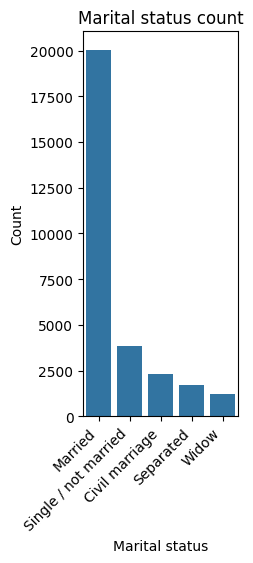

In [39]:
bar_plot(train_copy, 'Marital status')

{'Married': 320, 'Single / not married': 87, 'Civil marriage': 34, 'Widow': 34, 'Separated': 24}


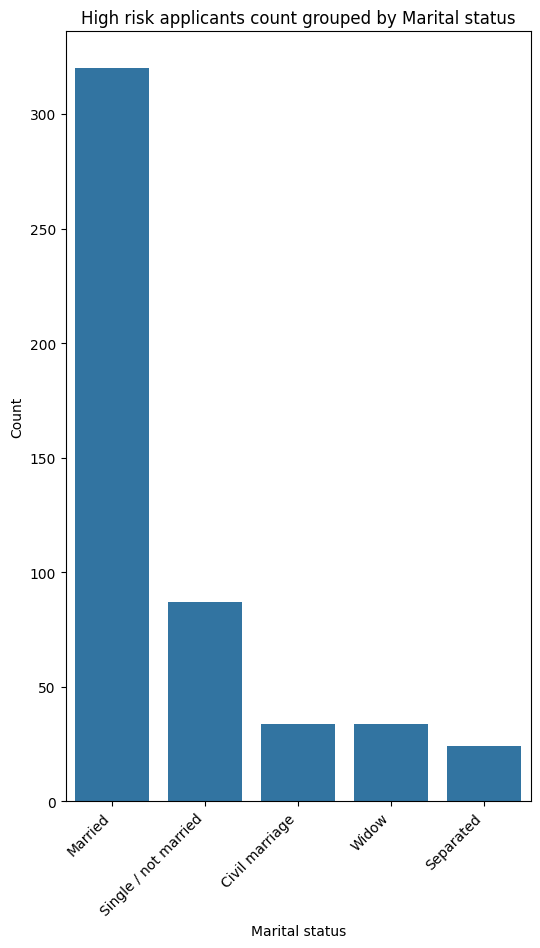

In [40]:
risk_bar_plot(train_copy, 'Marital status')

### Interpretaion

- Most applicants are married
- Even though we have a higher number of applicants who are seperated than those who are widow, it seems like widow applicants are high risk than those who are seperated.

## Family member count

In [41]:
gen_info_feat(train_copy, 'Family member count')

Description: 
count    29165.000000
mean         2.197531
std          0.912189
min          1.000000
25%          2.000000
50%          2.000000
75%          3.000000
max         20.000000
Name: Family member count, dtype: float64
--------------------------------------------------
Object type: 
float64
--------------------------------------------------
Value count: 
                     Count  Frequency (%)
Family member count                      
2.0                  15552      53.324190
1.0                   5613      19.245671
3.0                   5121      17.558718
4.0                   2503       8.582205
5.0                    309       1.059489
6.0                     48       0.164581
7.0                     14       0.048003
9.0                      2       0.006858
15.0                     2       0.006858
20.0                     1       0.003429


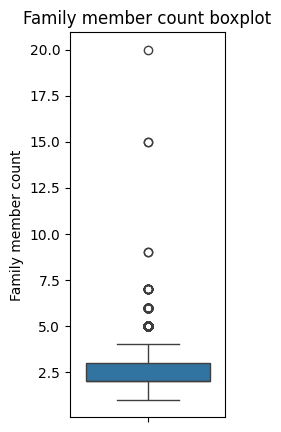

In [42]:
box_plot(train_copy, 'Family member count')

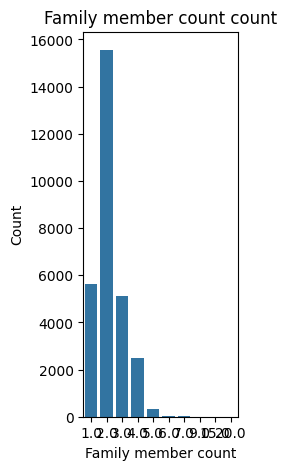

In [43]:
bar_plot(train_copy, 'Family member count')

### Interpreataion
- Most applicants are two in their household, this is also confirmend with the fact that most dont have a child.
- Any number higher than 4 ie 4 family members, is an outlier category.

## Children Count

In [44]:
gen_info_feat(train_copy, 'Children count')

Description: 
count    29165.000000
mean         0.430790
std          0.741882
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max         19.000000
Name: Children count, dtype: float64
--------------------------------------------------
Object type: 
int64
--------------------------------------------------
Value count: 
                Count  Frequency (%)
Children count                      
0               20143      69.065661
1                6003      20.582890
2                2624       8.997086
3                 323       1.107492
4                  52       0.178296
5                  15       0.051432
7                   2       0.006858
14                  2       0.006858
19                  1       0.003429


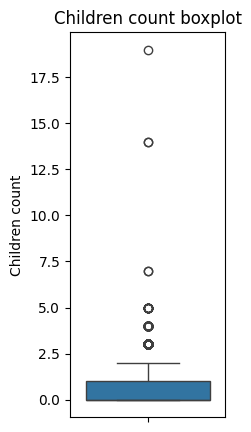

In [45]:
box_plot(train_copy, 'Children count')

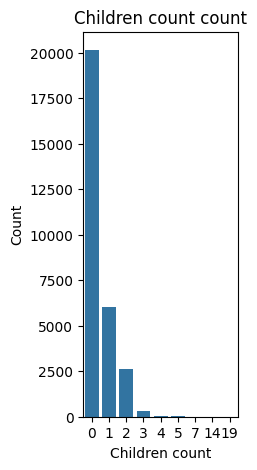

In [46]:
bar_plot(train_copy, 'Children count')

### Interpreataion
- Most applicants dont have a child
- Again we see that familes having children more than 2 are in the outlier categories

## Dwelling type

In [47]:
gen_info_feat(train_copy, 'Dwelling')

Description: 
count                 29165
unique                    6
top       House / apartment
freq                  26059
Name: Dwelling, dtype: object
--------------------------------------------------
Object type: 
object
--------------------------------------------------
Value count: 
                     Count  Frequency (%)
Dwelling                                 
House / apartment    26059      89.350249
With parents          1406       4.820847
Municipal apartment    912       3.127036
Rented apartment       453       1.553232
Office apartment       208       0.713184
Co-op apartment        127       0.435453


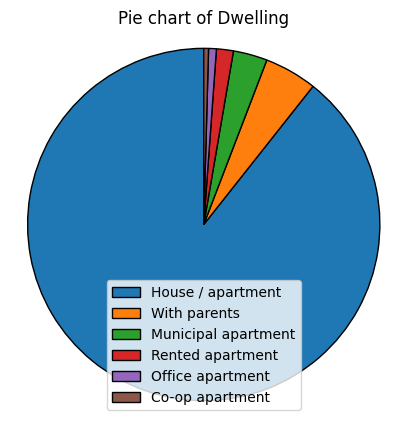

In [48]:
pie_plot(train_copy, 'Dwelling')

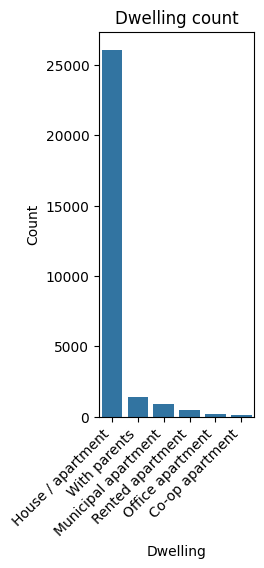

In [49]:
bar_plot(train_copy, 'Dwelling')

Interpreataion
- Almost every applicant live in a house or apartment

## Income

In [50]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
gen_info_feat(train_copy, 'Income')

Description: 
count     29165.00
mean     186890.39
std      101409.64
min       27000.00
25%      121500.00
50%      157500.00
75%      225000.00
max     1575000.00
Name: Income, dtype: float64
--------------------------------------------------
Object type: 
float64
--------------------------------------------------
Value count: 
           Count  Frequency (%)
Income                         
135000.00   3468          11.89
180000.00   2487           8.53
157500.00   2469           8.47
225000.00   2373           8.14
112500.00   2359           8.09
...          ...            ...
164250.00      1           0.00
42300.00       1           0.00
432000.00      1           0.00
145350.00      1           0.00
82350.00       1           0.00

[259 rows x 2 columns]


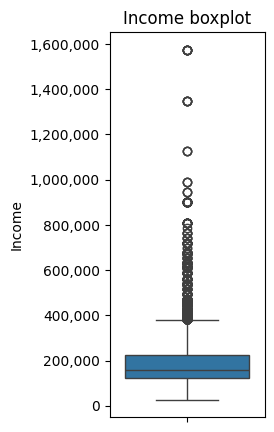

In [51]:
box_plot(train_copy, 'Income')

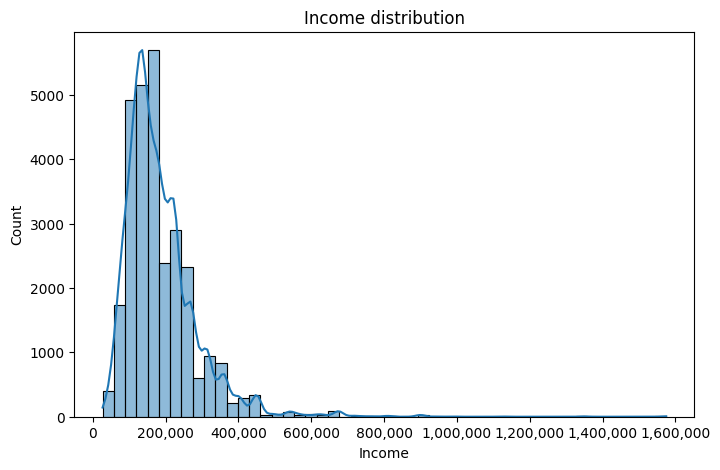

In [52]:
hist_plot(train_copy, 'Income')

Bivariate Analysis with the target variable

Is high risk
0   186913.94
1   185537.26
Name: Income, dtype: float64


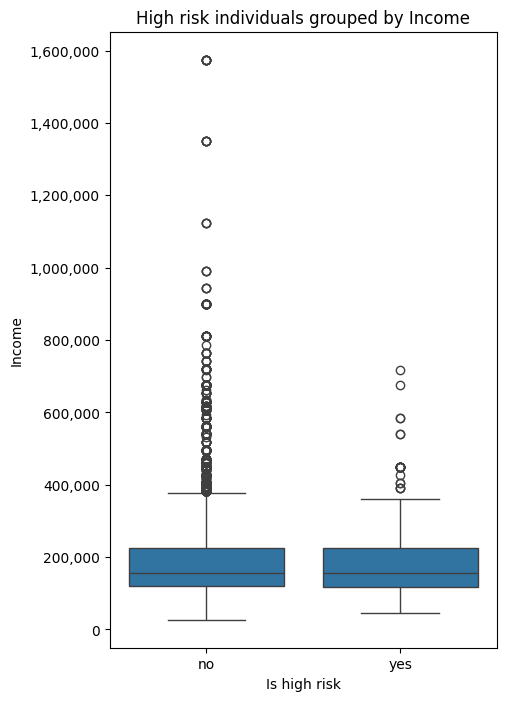

In [53]:
risk_box_plot(train_copy, 'Income')

### Interpreataion
- The minimum and maximum income are 27,000 and 1,575,000 respectively with the mean being 186,890 and median 157,500. Since there are outliers the actual mean would be around the median.
- There are 3 applicants whose income is more than 1,000,000
- The income is positively skewed
- High risk and low risk applicants have roughly similar income

In [54]:
gen_info_feat(train_copy,'Job title')

Description: 
count        20138
unique          18
top       Laborers
freq          5004
Name: Job title, dtype: object
--------------------------------------------------
Object type: 
object
--------------------------------------------------
Value count: 
                       Count  Frequency (%)
Job title                                  
Laborers                5004          24.85
Core staff              2866          14.23
Sales staff             2773          13.77
Managers                2422          12.03
Drivers                 1722           8.55
High skill tech staff   1133           5.63
Accountants              998           4.96
Medicine staff           956           4.75
Cooking staff            521           2.59
Security staff           464           2.30
Cleaning staff           425           2.11
Private service staff    287           1.43
Low-skill Laborers       138           0.69
Waiters/barmen staff     127           0.63
Secretaries              122          

In [55]:
job_title_nan_count = train_copy['Job title'].isna().sum()
job_title_nan_count

9027

In [56]:
rows_total_count = train_copy.shape[0]
print('The percentage of missing rows is {:.2f} %'.format(job_title_nan_count * 100 / rows_total_count))

The percentage of missing rows is 30.95 %


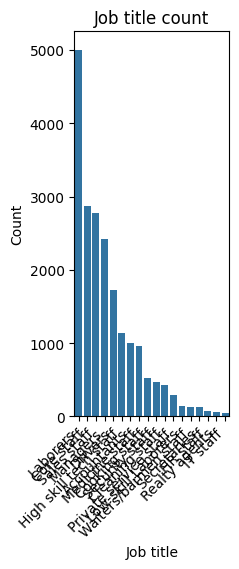

In [57]:
bar_plot(train_copy,'Job title')

# Employment status

In [58]:
gen_info_feat(train_copy,'Employment status')


Description: 
count       29165
unique          5
top       Working
freq        15056
Name: Employment status, dtype: object
--------------------------------------------------
Object type: 
object
--------------------------------------------------
Value count: 
                      Count  Frequency (%)
Employment status                         
Working               15056          51.62
Commercial associate   6801          23.32
Pensioner              4920          16.87
State servant          2381           8.16
Student                   7           0.02


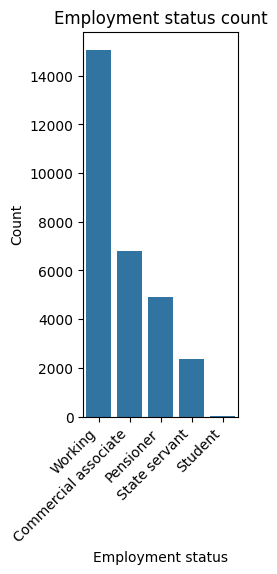

In [59]:
bar_plot(train_copy,'Employment status')


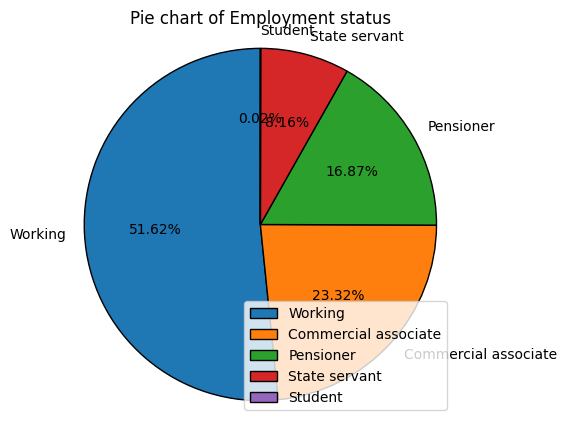

In [60]:
pie_plot(train_copy,'Employment status')

# Education level

In [61]:
gen_info_feat(train_copy,'Education level')

Description: 
count                             29165
unique                                5
top       Secondary / secondary special
freq                              19803
Name: Education level, dtype: object
--------------------------------------------------
Object type: 
object
--------------------------------------------------
Value count: 
                               Count  Frequency (%)
Education level                                    
Secondary / secondary special  19803          67.90
Higher education                7910          27.12
Incomplete higher               1129           3.87
Lower secondary                  298           1.02
Academic degree                   25           0.09


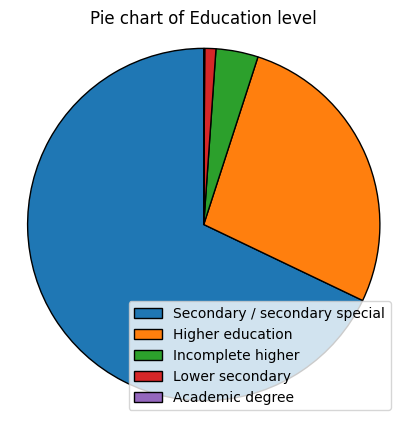

In [62]:
pie_plot(train_copy,'Education level')


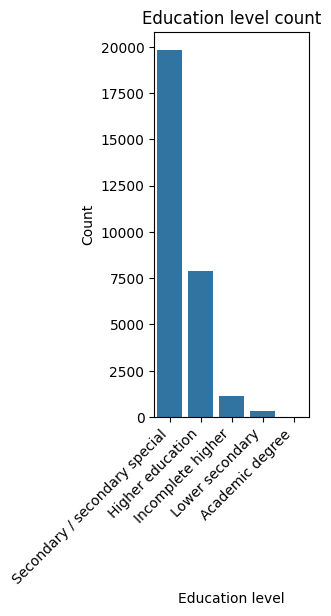

In [63]:
bar_plot(train_copy,'Education level')


# Employment length

In [64]:
gen_info_feat(train_copy,'Employment length')


Description: 
count    29165.00
mean     59257.76
std     137655.88
min     -15713.00
25%      -3153.00
50%      -1557.00
75%       -412.00
max     365243.00
Name: Employment length, dtype: float64
--------------------------------------------------
Object type: 
int64
--------------------------------------------------
Value count: 
                   Count  Frequency (%)
Employment length                      
 365243             4908          16.83
-401                  61           0.21
-200                  55           0.19
-2087                 53           0.18
-1539                 51           0.17
...                  ...            ...
-8369                  1           0.00
-6288                  1           0.00
-6303                  1           0.00
-3065                  1           0.00
-8256                  1           0.00

[3483 rows x 2 columns]


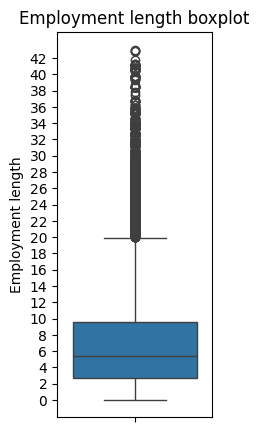

In [65]:
box_plot(train_copy,'Employment length')


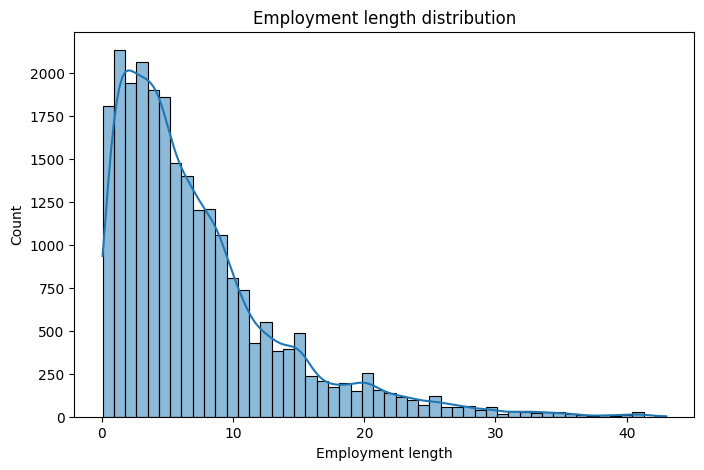

In [66]:
hist_plot(train_copy,'Employment length')


Is high risk
0   7.29
1   5.75
Name: Employment length, dtype: float64


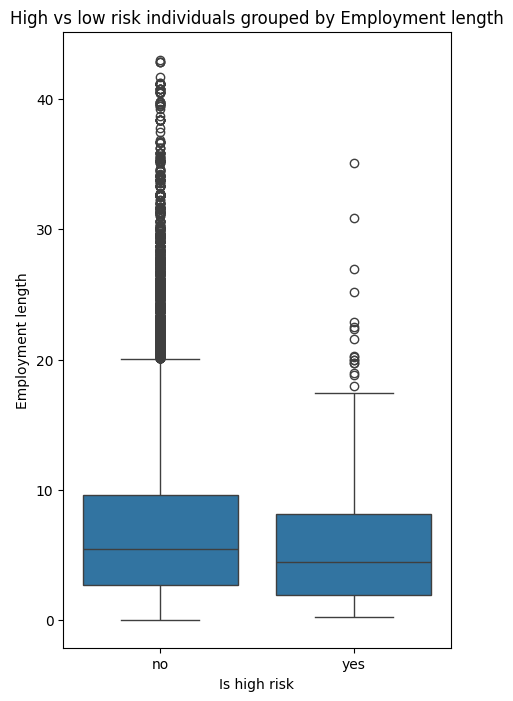

In [67]:
risk_box_plot(train_copy,'Employment length')

# Has a car

In [68]:
gen_info_feat(train_copy,'Has a car')

Description: 
count     29165
unique        2
top           N
freq      18128
Name: Has a car, dtype: object
--------------------------------------------------
Object type: 
object
--------------------------------------------------
Value count: 
           Count  Frequency (%)
Has a car                      
N          18128          62.16
Y          11037          37.84


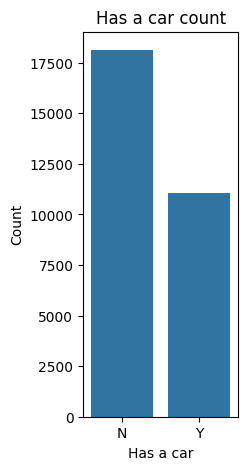

In [69]:
bar_plot(train_copy,'Has a car')


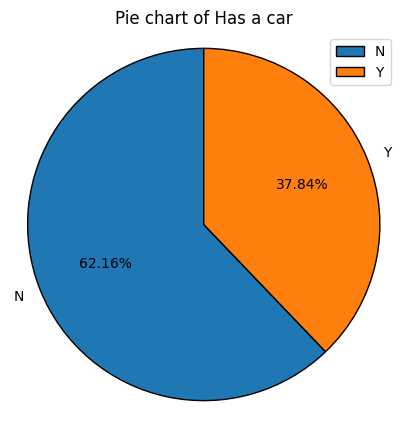

In [70]:
pie_plot(train_copy,'Has a car')


# Has a property

In [71]:
gen_info_feat(train_copy,'Has a property')


Description: 
count     29165
unique        2
top           Y
freq      19557
Name: Has a property, dtype: object
--------------------------------------------------
Object type: 
object
--------------------------------------------------
Value count: 
                Count  Frequency (%)
Has a property                      
Y               19557          67.06
N                9608          32.94


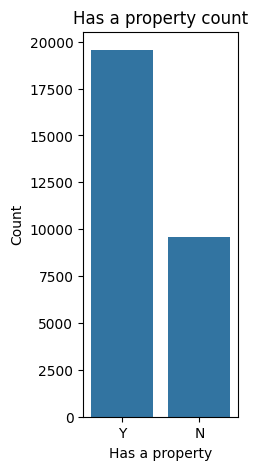

In [72]:
bar_plot(train_copy,'Has a property')


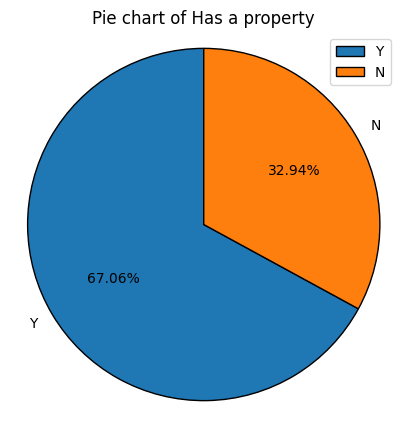

In [73]:
pie_plot(train_copy,'Has a property')


# Has a work phone

In [74]:
gen_info_feat(train_copy,'Has a work phone')


Description: 
count   29165.00
mean        0.22
std         0.42
min         0.00
25%         0.00
50%         0.00
75%         0.00
max         1.00
Name: Has a work phone, dtype: float64
--------------------------------------------------
Object type: 
int64
--------------------------------------------------
Value count: 
                  Count  Frequency (%)
Has a work phone                      
0                 22623          77.57
1                  6542          22.43


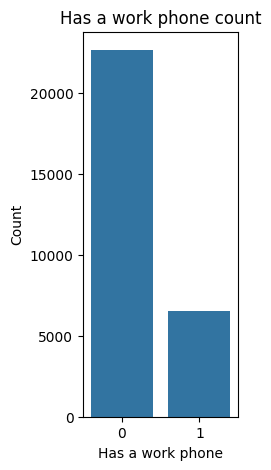

In [75]:
bar_plot(train_copy,'Has a work phone')


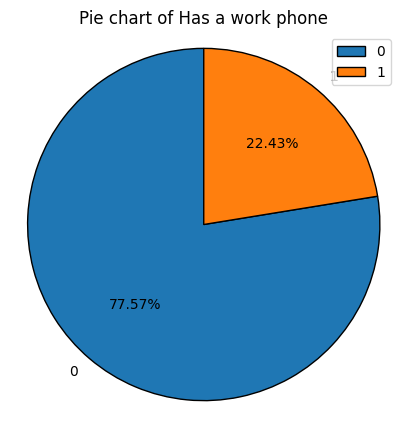

In [76]:
pie_plot(train_copy,'Has a work phone')


# Has a mobile phone

In [77]:
gen_info_feat(train_copy,'Has a mobile phone')


Description: 
count   29165.00
mean        1.00
std         0.00
min         1.00
25%         1.00
50%         1.00
75%         1.00
max         1.00
Name: Has a mobile phone, dtype: float64
--------------------------------------------------
Object type: 
int64
--------------------------------------------------
Value count: 
                    Count  Frequency (%)
Has a mobile phone                      
1                   29165         100.00


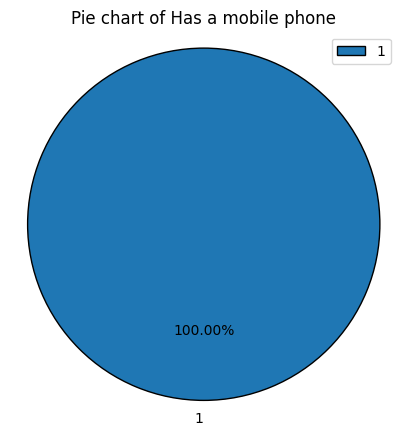

In [78]:
pie_plot(train_copy,'Has a mobile phone')


# Has a phone

In [79]:
gen_info_feat(train_copy,'Has a phone')


Description: 
count   29165.00
mean        0.29
std         0.46
min         0.00
25%         0.00
50%         0.00
75%         1.00
max         1.00
Name: Has a phone, dtype: float64
--------------------------------------------------
Object type: 
int64
--------------------------------------------------
Value count: 
             Count  Frequency (%)
Has a phone                      
0            20562          70.50
1             8603          29.50


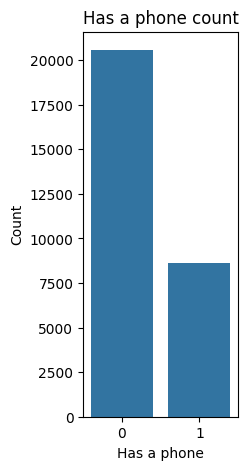

In [80]:
bar_plot(train_copy,'Has a phone')


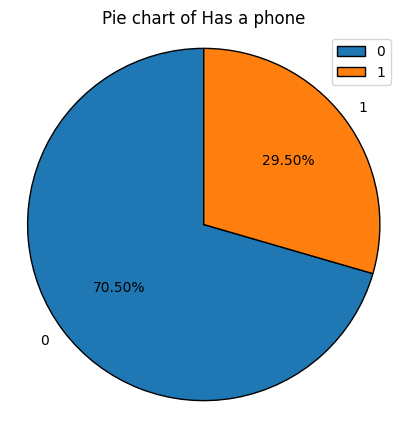

In [81]:
pie_plot(train_copy,'Has a phone')


# Has an email

In [82]:
gen_info_feat(train_copy,'Has an email')


Description: 
count   29165.00
mean        0.09
std         0.29
min         0.00
25%         0.00
50%         0.00
75%         0.00
max         1.00
Name: Has an email, dtype: float64
--------------------------------------------------
Object type: 
int64
--------------------------------------------------
Value count: 
              Count  Frequency (%)
Has an email                      
0             26532          90.97
1              2633           9.03


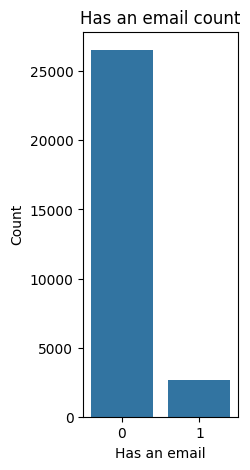

In [83]:
bar_plot(train_copy,'Has an email')


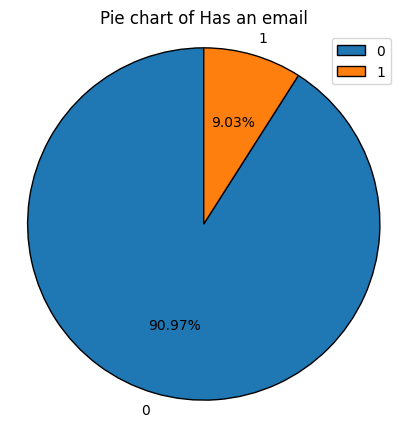

In [84]:
pie_plot(train_copy,'Has an email')


# Account age

In [85]:
gen_info_feat(train_copy,'Account age')


Description: 
count   29165.00
mean       26.14
std        16.49
min         0.00
25%        12.00
50%        24.00
75%        39.00
max        60.00
Name: Account age, dtype: float64
--------------------------------------------------
Object type: 
float64


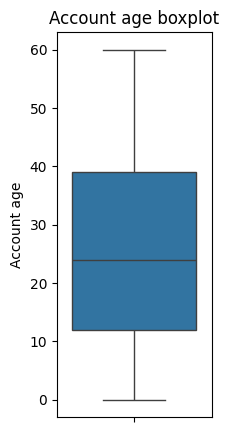

In [86]:
box_plot(train_copy,'Account age')


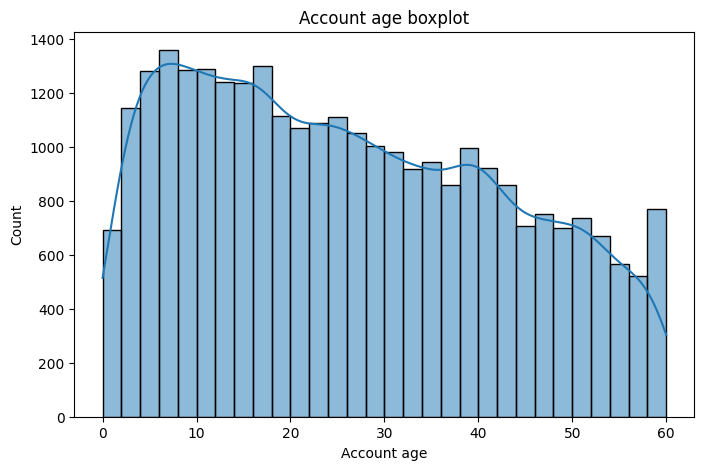

In [87]:
hist_plot(train_copy,'Account age', bins=30)


Is high risk
0   26.00
1   34.04
Name: Account age, dtype: float64


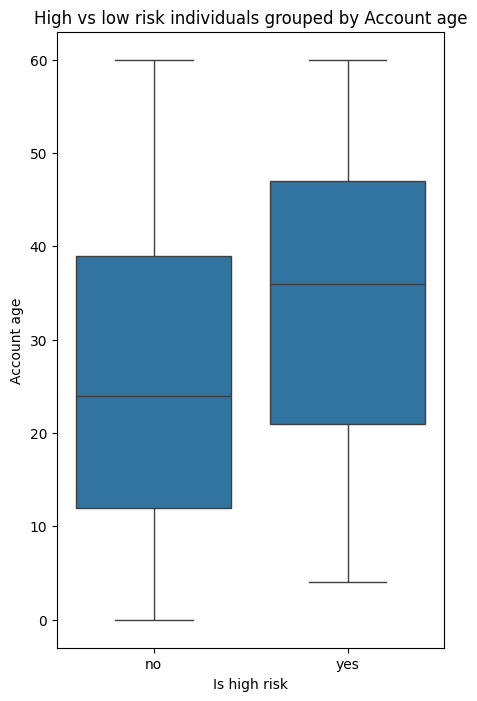

In [88]:
risk_box_plot(train_copy,'Account age')


# Is high risk (target variable)

In [89]:
gen_info_feat(train_copy,'Is high risk')


Description: 
count     29165
unique        2
top           0
freq      28666
Name: Is high risk, dtype: int64
--------------------------------------------------
Object type: 
object
--------------------------------------------------
Value count: 
              Count  Frequency (%)
Is high risk                      
0             28666          98.29
1               499           1.71


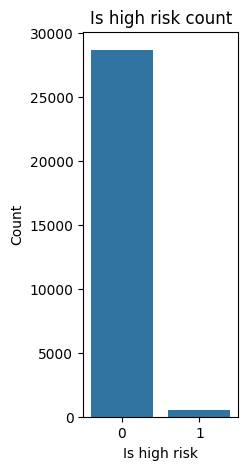

In [90]:
bar_plot(train_copy,'Is high risk')


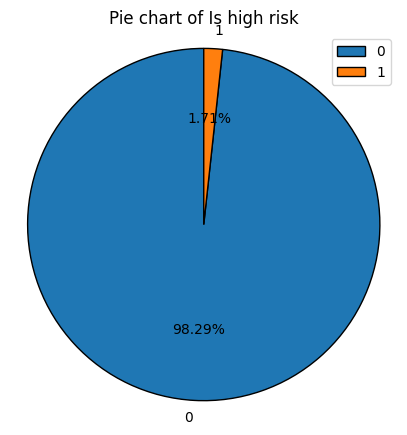

In [91]:
pie_plot(train_copy,'Is high risk')


# Bivariate analysis

## Numerical vs numerical features 

### Scatter plots

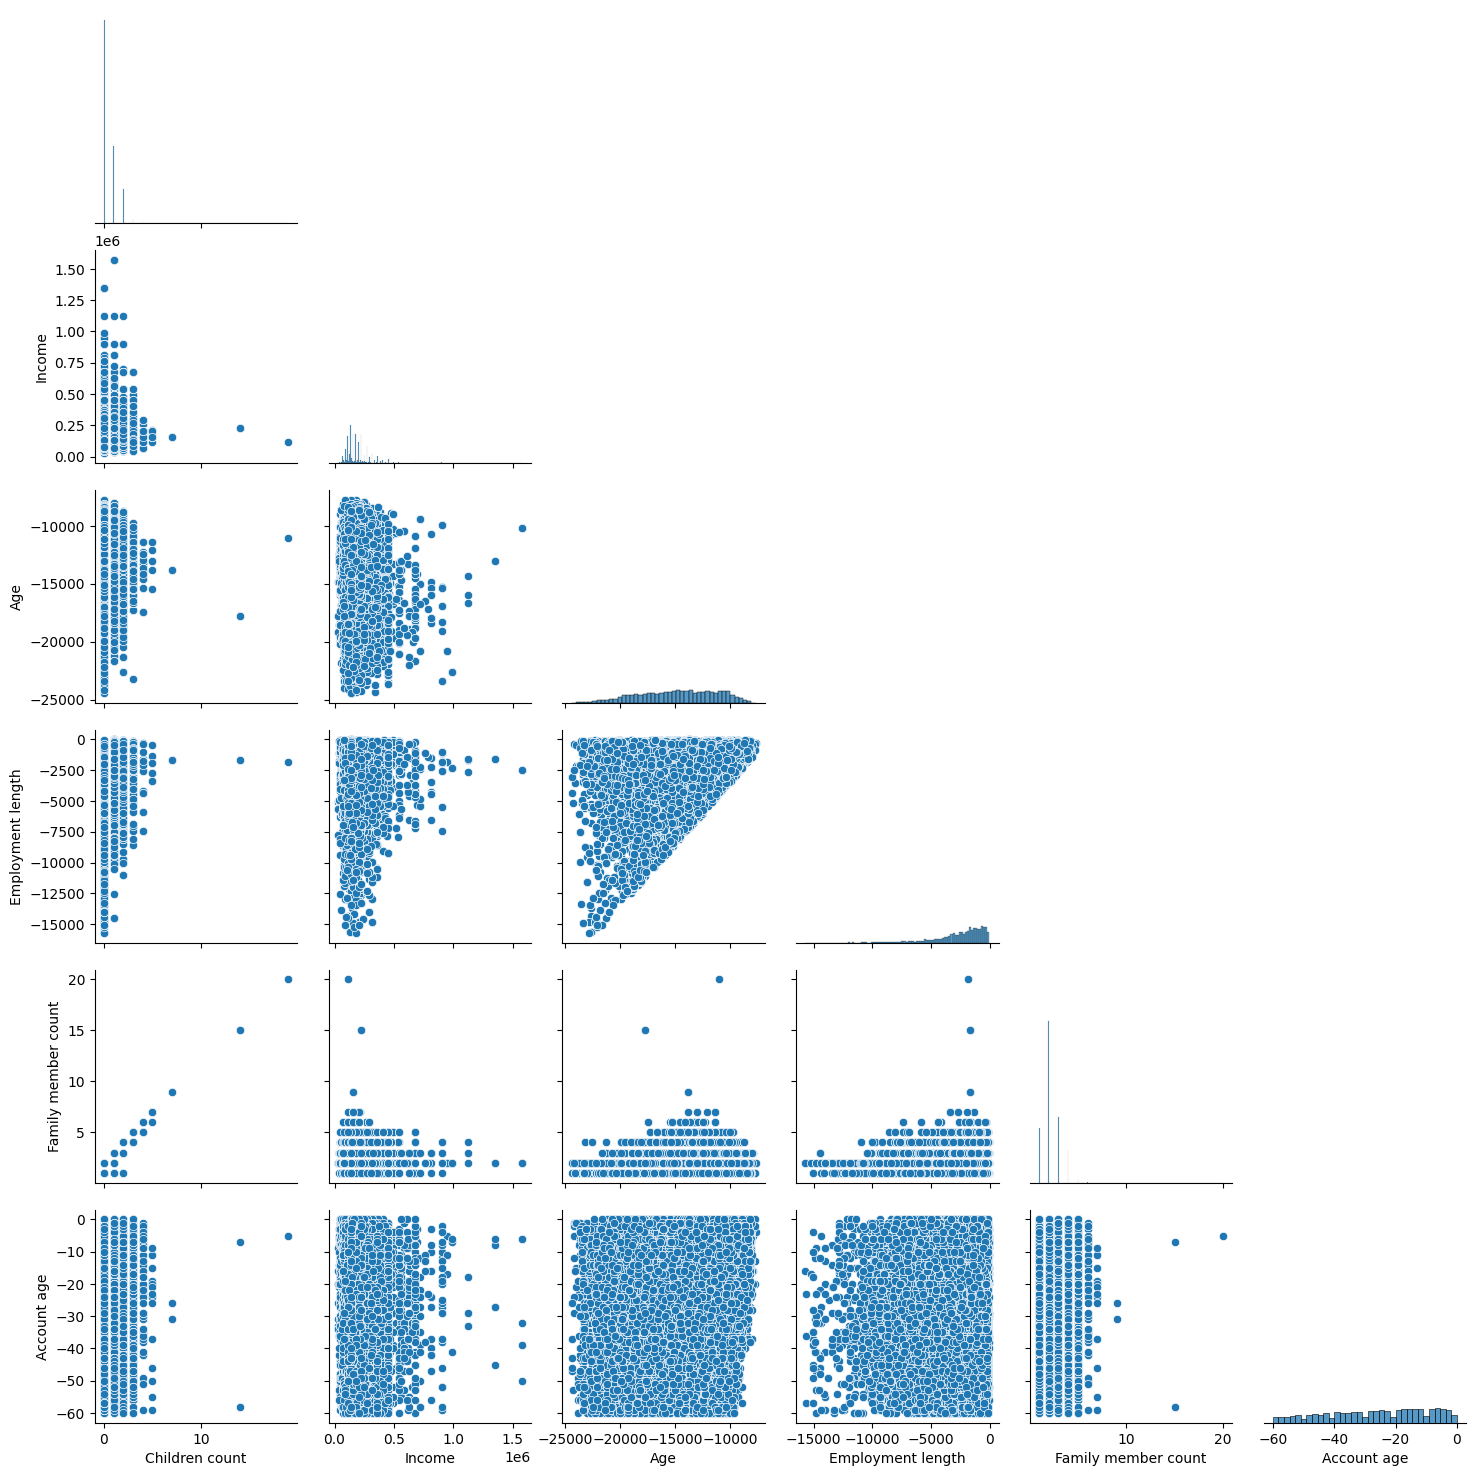

In [92]:
sns.pairplot(train_copy[train_copy['Employment length'] < 0].drop(['ID','Has a mobile phone', 'Has a work phone', 'Has a phone', 'Has an email','Is high risk'],axis=1),corner=True)
plt.show()

Family member count vs children count (numerical vs numerical feature comparison)

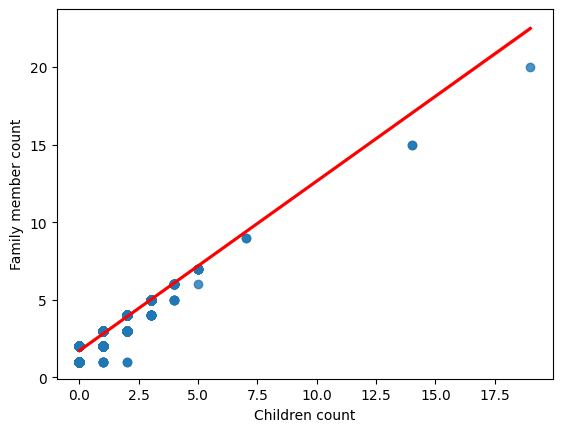

In [94]:
sns.regplot(x='Children count',y='Family member count',data=train_copy,line_kws={'color': 'red'})
plt.show()

Account age vs age (numerical vs numerical feature comparison)

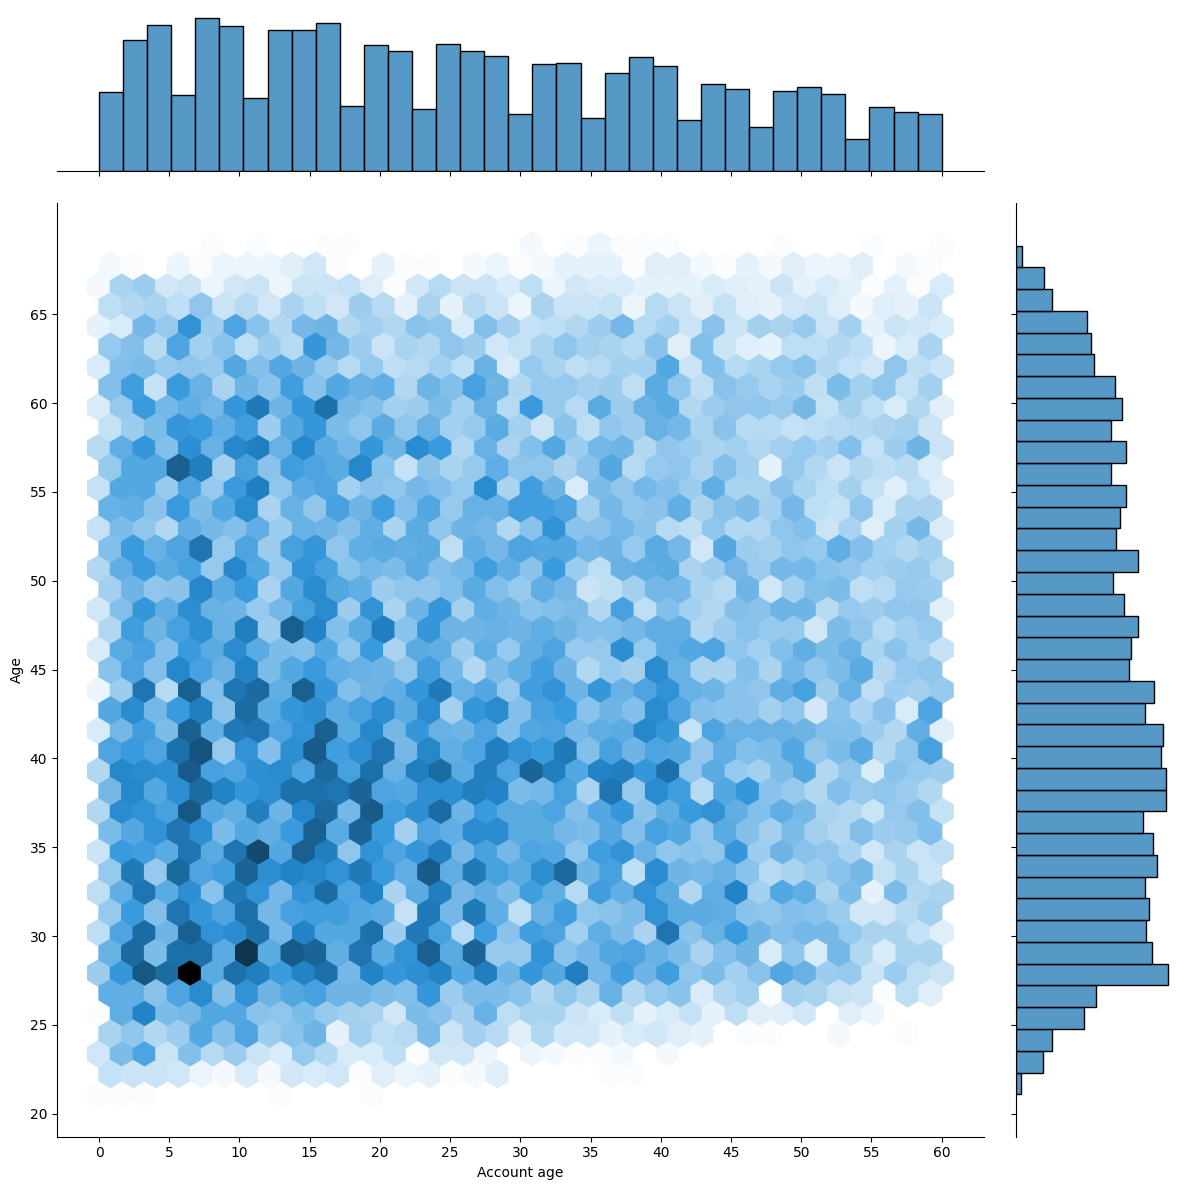

In [99]:
y_age = np.abs(train_copy['Age'])/365.25
sns.jointplot(x= np.abs(train_copy['Account age']),y=y_age, kind="hex", height=12)
plt.yticks(np.arange(20, y_age.max(), 5))
plt.xticks(np.arange(0, 65, 5))
plt.ylabel('Age')
plt.show()

Employment length vs age (numerical vs numerical feature comparison)

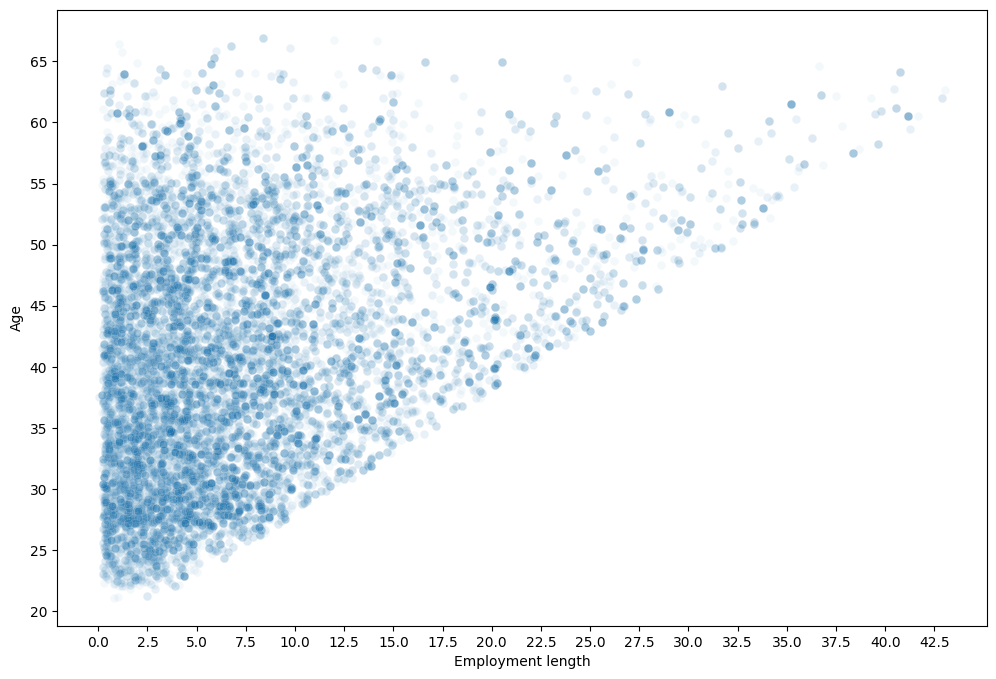

In [101]:
x_employ_length = np.abs(train_copy[train_copy['Employment length'] < 0]['Employment length'])/365.25
fig, ax = plt.subplots(figsize=(12,8))
sns.scatterplot(x= x_employ_length,y = y_age,alpha=.05)
# change the frequency of the x-axis and y-axis labels
plt.xticks(np.arange(0, x_employ_length.max(), 2.5))
plt.yticks(np.arange(20, y_age.max(), 5))
plt.show()

Correlation analysis

In [104]:
# change the datatype of target feature to int
is_high_risk_int = train_copy['Is high risk'].astype('int32')

ID  Children count  Income   Age  Employment length  \
ID                   1.00            0.03   -0.02  0.05              -0.04   
Children count       0.03            1.00    0.03  0.34              -0.23   
Income              -0.02            0.03    1.00  0.07              -0.17   
Age                  0.05            0.34    0.07  1.00              -0.62   
Employment length   -0.04           -0.23   -0.17 -0.62               1.00   
Has a mobile phone    NaN             NaN     NaN   NaN                NaN   
Has a work phone     0.09            0.05   -0.04  0.18              -0.24   
Has a phone          0.01           -0.02    0.02 -0.03              -0.01   
Has an email        -0.05            0.02    0.09  0.10              -0.09   
Family member count  0.02            0.89    0.03  0.30              -0.22   
Account age         -0.00           -0.00   -0.02  0.06               0.01   
Is high risk         0.01            0.00   -0.00  0.00               0.01   

                     Has a mobile phone  Has a work phone  Has a phone  \
ID                                  NaN              0.09         0.01   
Children count                      NaN              0.05        -0.02   
Income                              NaN             -0.04         0.02   
Age                                 NaN              0.18        -0.03   
Employment length                   NaN             -0.24        -0.01   
Has a mobile phone                  NaN               NaN          NaN   
Has a work phone                    NaN              1.00         0.31   
Has a phone                         NaN              0.31         1.00   
Has an email                        NaN             -0.04         0.01   
Family member count                 NaN              0.07        -0.00   
Account age                         NaN             -0.01        -0.01   
Is high risk                        NaN              0.01        -0.00   

                     Has an email  Family member count  Account age  \
ID                          -0.05                 0.02        -0.00   
Children count               0.02                 0.89        -0.00   
Income                       0.09                 0.03        -0.02   
Age                          0.10                 0.30         0.06   
Employment length           -0.09                -0.22         0.01   
Has a mobile phone            NaN                  NaN          NaN   
Has a work phone            -0.04                 0.07        -0.01   
Has a phone                  0.01                -0.00        -0.01   
Has an email                 1.00                 0.01         0.00   
Family member count          0.01                 1.00        -0.02   
Account age                  0.00                -0.02         1.00   
Is high risk                -0.00                -0.01        -0.06   

                     Is high risk  
ID                           0.01  
Children count               0.00  
Income                      -0.00  
Age                          0.00  
Employment length            0.01  
Has a mobile phone            NaN  
Has a work phone             0.01  
Has a phone                 -0.00  
Has an email                -0.00  
Family member count         -0.01  
Account age                 -0.06  
Is high risk                 1.00

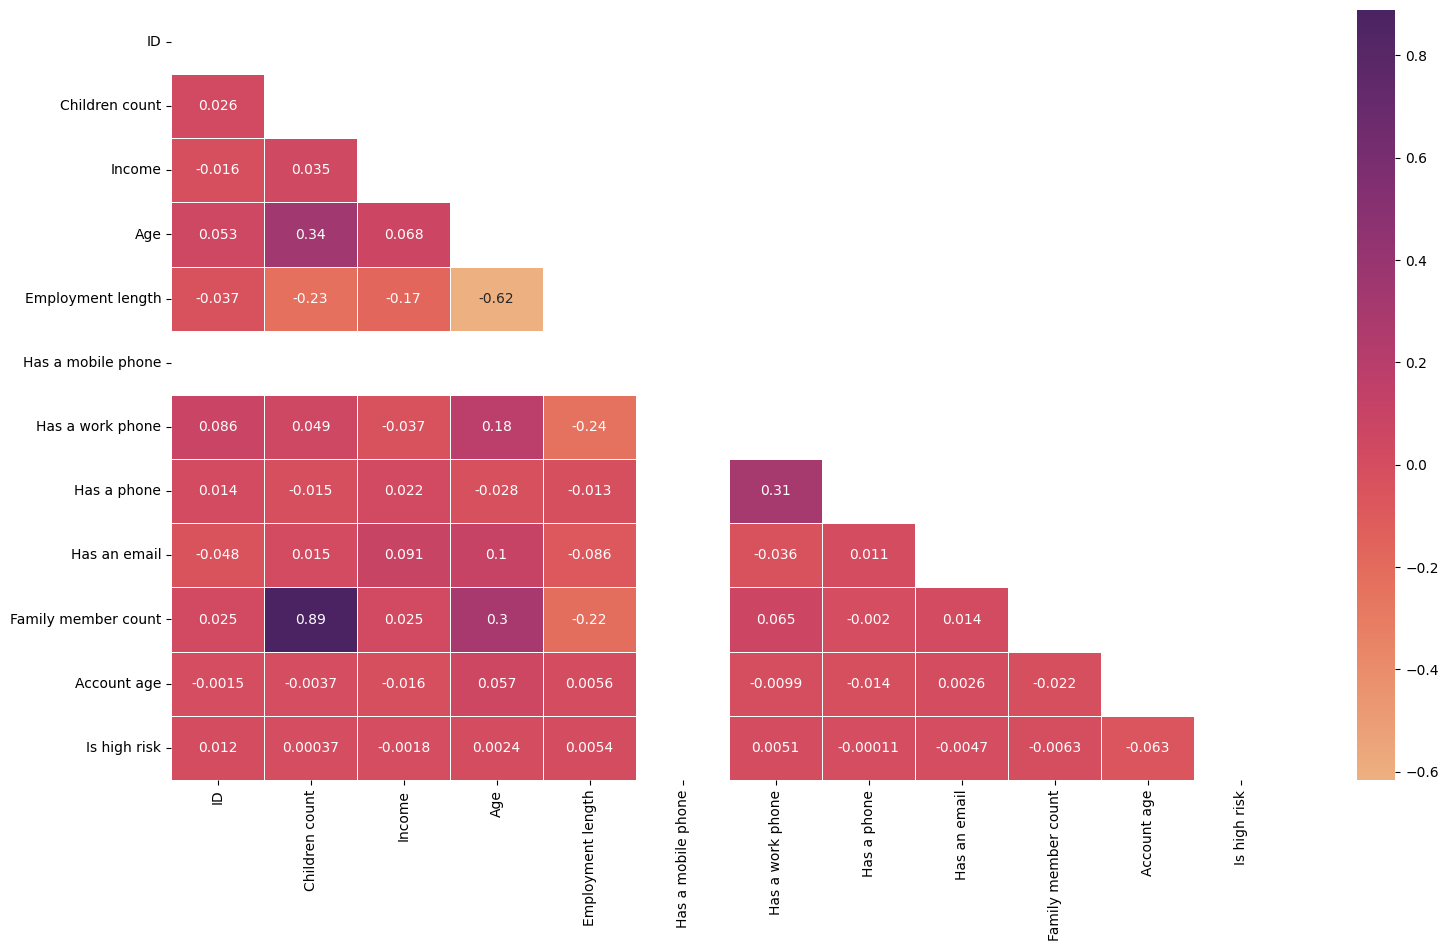

In [112]:
# correlation analysis with heatmap, after dropping the has a mobile phone with the target feature as int
cc_train_copy_corr_no_mobile = pd.concat([train_copy.drop(train_copy.select_dtypes(include=['object']).columns, axis=1),is_high_risk_int],axis=1).corr()
# Get the lower triangle of the correlation matrix
# Generate a mask for the upper triangle
mask = np.zeros_like(cc_train_copy_corr_no_mobile, dtype='bool')
mask[np.triu_indices_from(mask)] = True
# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(18,10))
# seaborn heatmap
sns.heatmap(cc_train_copy_corr_no_mobile, annot=True, cmap='flare',mask=mask, linewidths=.5)
# plot the heatmap
plt.show()

## Numerical vs categorical features (ANOVA)

### Age vs the rest of categorical features

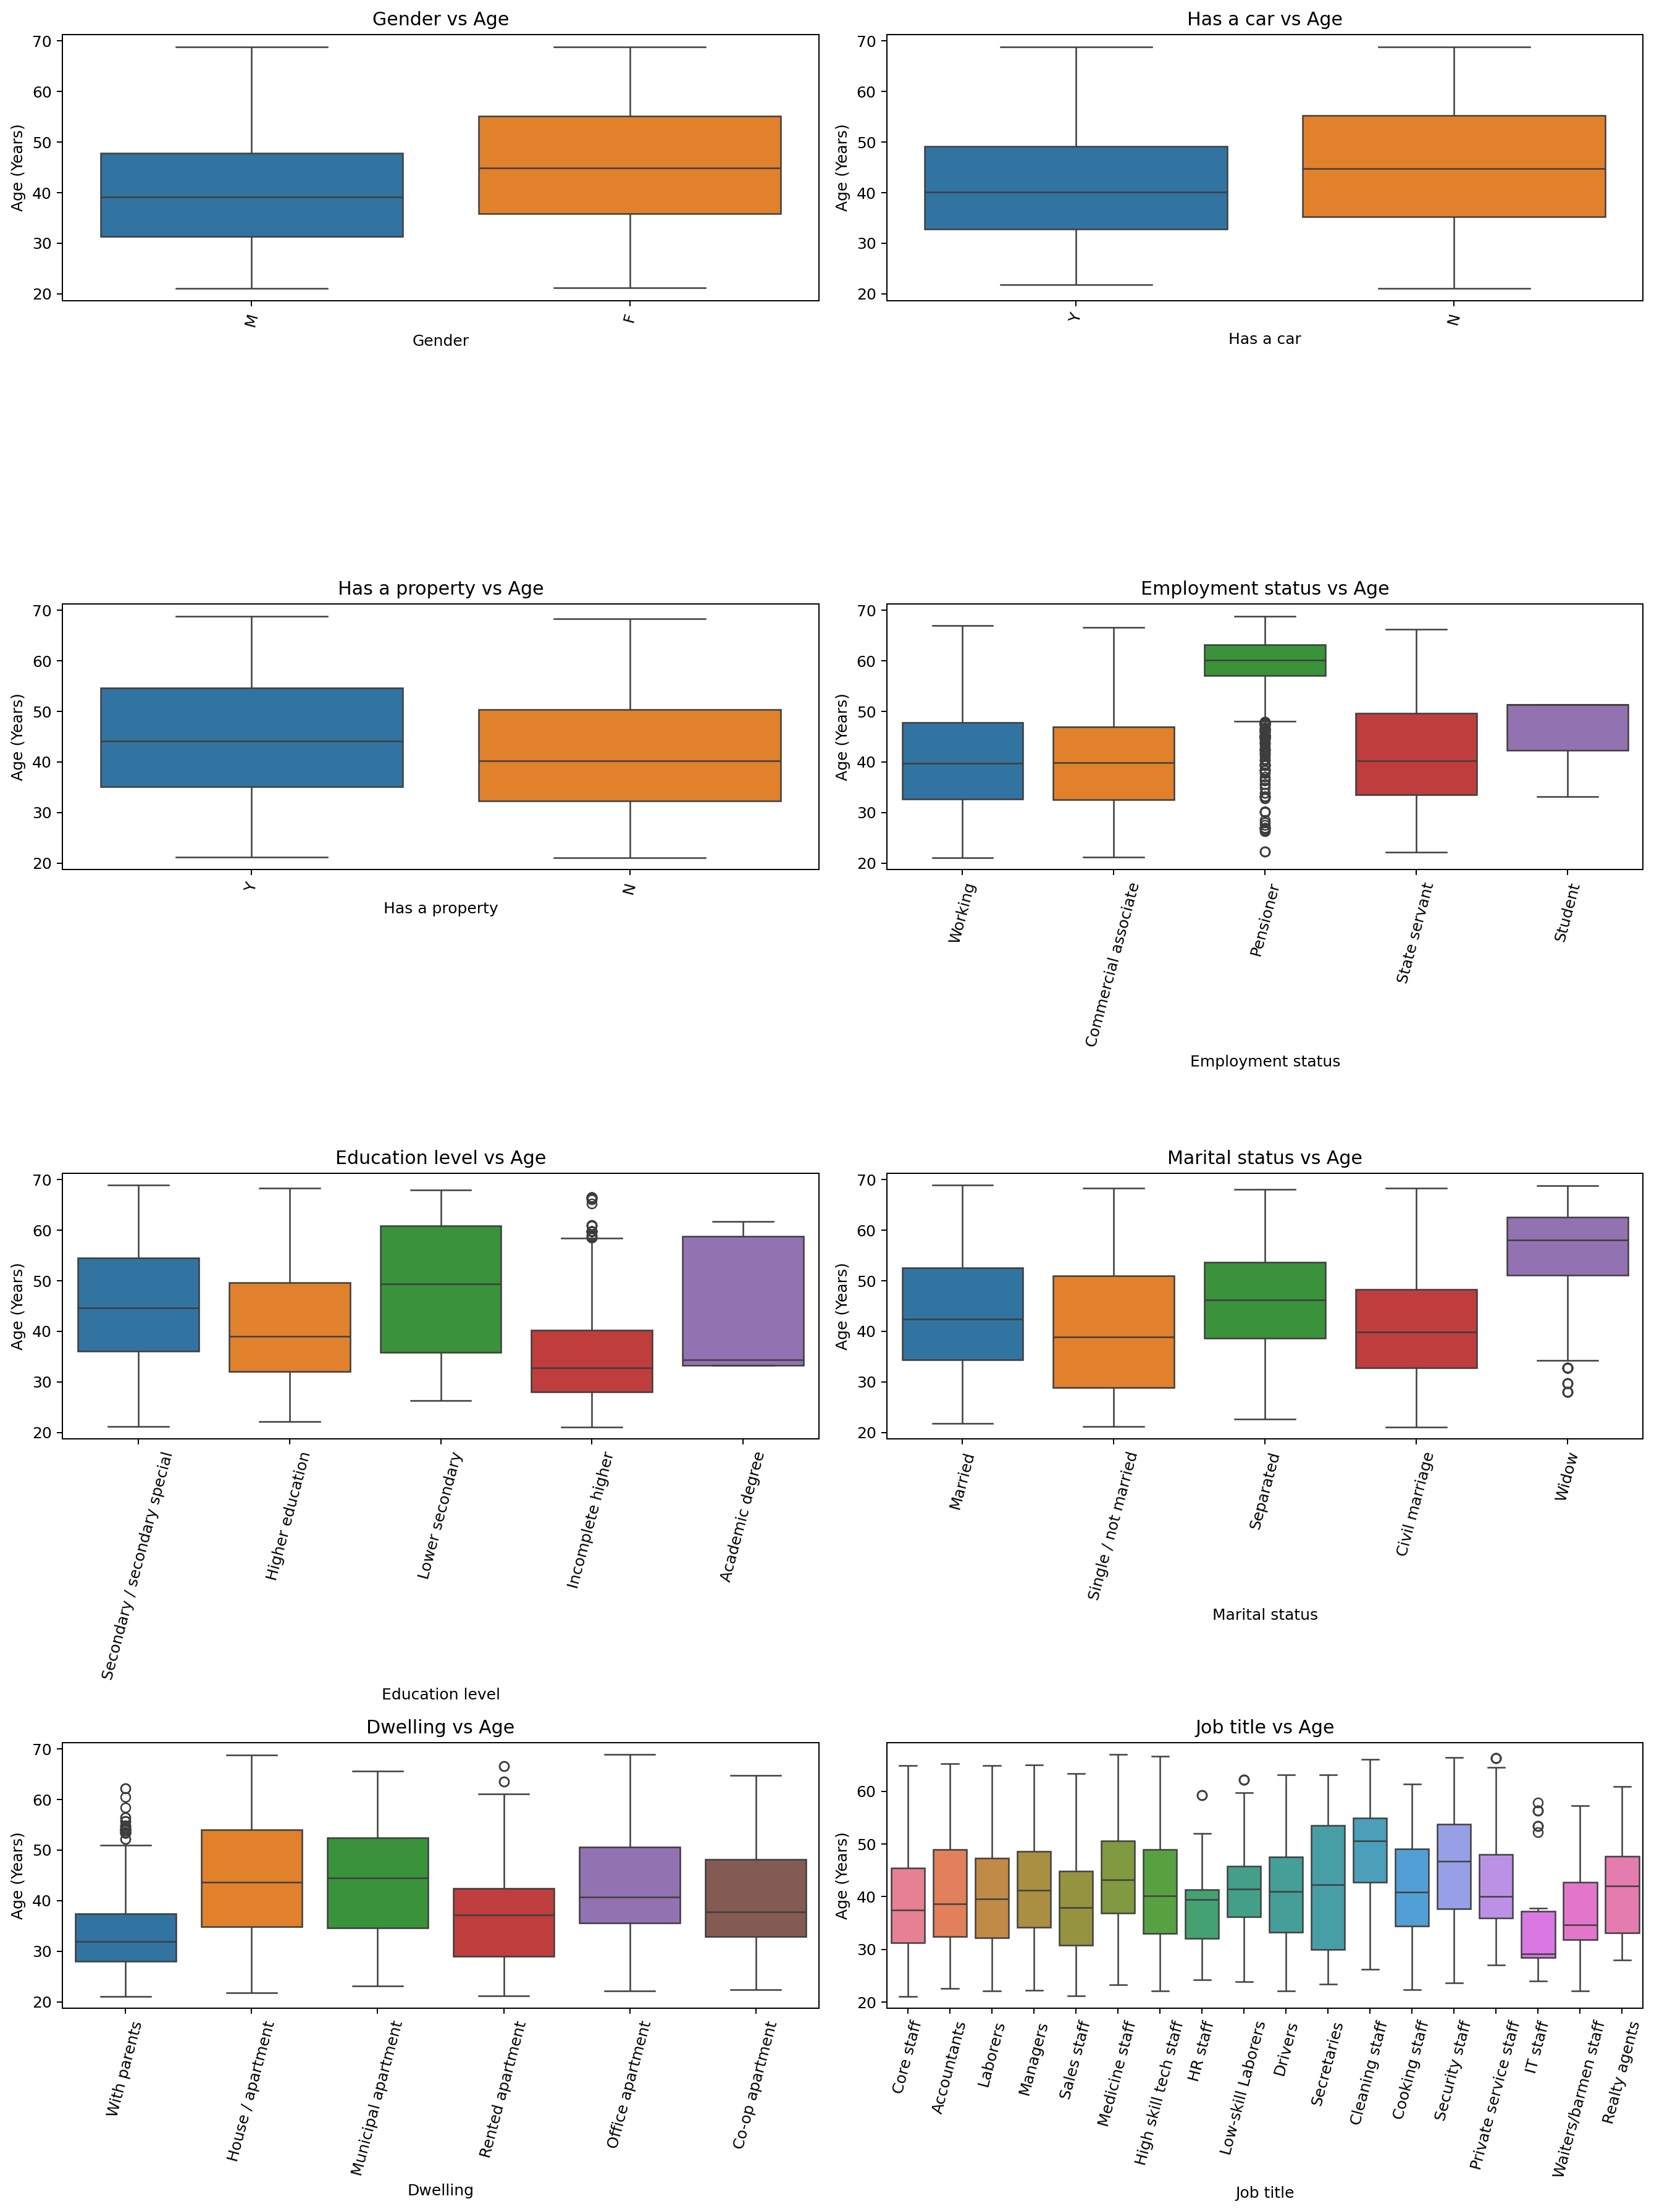

In [124]:
cat_features = ['Gender', 'Has a car', 'Has a property', 'Employment status', 'Education level', 'Marital status', 'Dwelling', 'Job title']

fig, axes = plt.subplots(4, 2, figsize=(15, 20), dpi=180)
fig.tight_layout(pad=5.0)

axes = axes.flatten()

for cat_ft_count, feature in enumerate(cat_features):
    sns.boxplot(ax=axes[cat_ft_count], x=train_copy[feature], y=np.abs(train_copy['Age']) / 365.25, hue=train_copy[feature])
    axes[cat_ft_count].set_title(f"{feature} vs Age")
    axes[cat_ft_count].set_ylabel('Age (Years)')
    axes[cat_ft_count].set_xlabel(feature)
    axes[cat_ft_count].tick_params(axis='x', rotation=75)
    
    if axes[cat_ft_count].legend_ is not None:
        axes[cat_ft_count].legend_.remove()

plt.tight_layout()
plt.show()


### Income vs the rest of categorical features

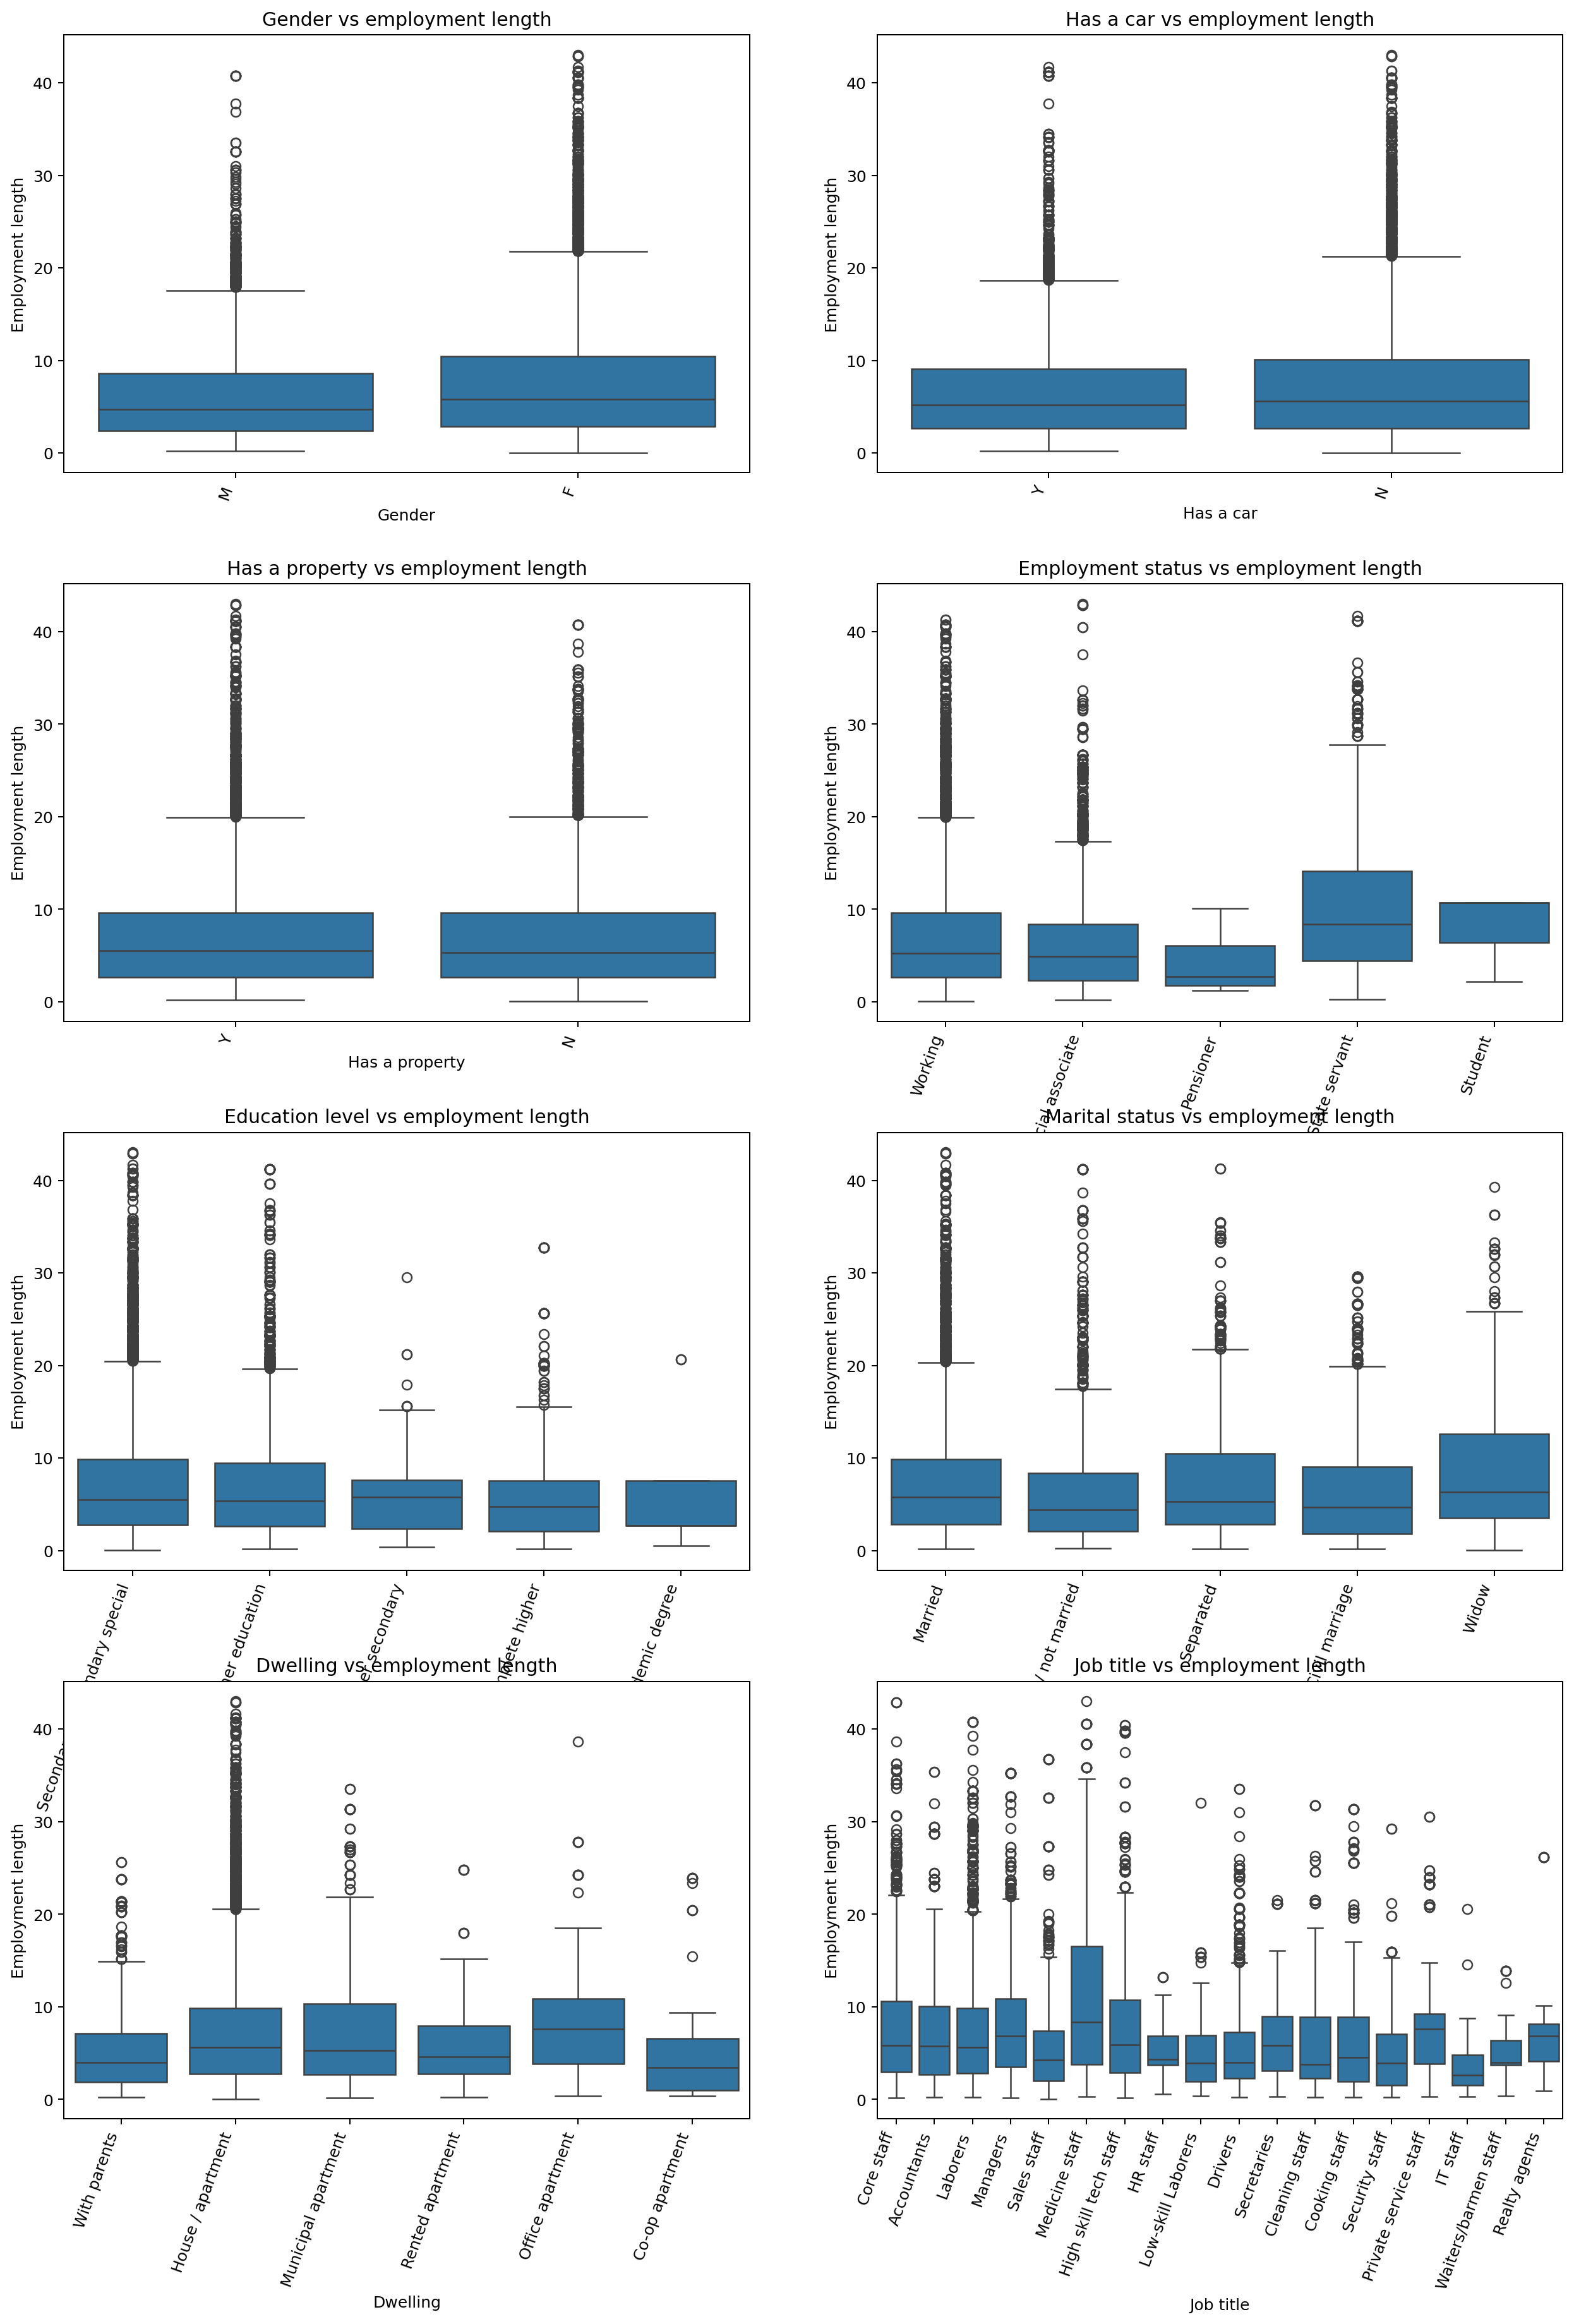

In [127]:
fig, axes = plt.subplots(4,2,figsize=(15,20),dpi=180)
fig.tight_layout(pad=5.0)

for cat_ft_count, ax in enumerate(axes):
    for row_count in range(4):
        for feat_count in range(2):
            sns.boxplot(ax=axes[row_count,feat_count],x=train_copy[cat_features[cat_ft_count]],y=np.abs(train_copy[train_copy['Employment length'] < 0]['Employment length'])/365.25)
            axes[row_count,feat_count].set_title(cat_features[cat_ft_count] + " vs employment length")
            plt.sca(axes[row_count,feat_count])
            plt.ylabel('Employment length')
            plt.xticks(rotation=70,ha='right')
            cat_ft_count += 1
    break

## Categorical vs categorical features (Chi-square test)

Null hypothesis: the feature's categories have no effect on the target variable.

Alternate hypothesis: one(or more) of the feature categories has a significant effect on the target variable.

In [ ]:
from scipy.stats import chi2_contingency
import pandas as pd

# Define the chi-square test function
def chi_sq(feature):
    # Generate the contingency table
    contingency_table = pd.crosstab(train_copy[feature], train_copy['Is high risk'])
    # Perform the chi-square test
    stat, p, dof, expected = chi2_contingency(contingency_table)
    
    # Print the results
    print(f"\n**** {feature} ****\n")
    print(f"Chi-Square Statistic: {stat}")
    print(f"p-value: {p}")
    # print(f"Degrees of Freedom: {dof}")
    # print(f"Expected Frequencies:\n{expected}")
    if p < 0.05:
        print(f"Since p vlaue < 0.05 we reject the null hypothesis and conclude {feature} has significant effect on the target variable")
    else:
        print(f"Since p vlaue > 0.05 we fail to reject the null hypothesis and conclude {feature} does not have a significant effect on the target variable")
        

# List of categorical features
cat_features = ['Gender', 'Has a car', 'Has a property', 'Employment status',
                'Education level', 'Marital status', 'Dwelling', 'Job title']

# Apply the chi-square test for each feature
for feature in cat_features:
    chi_sq(feature)



**** Gender ****

Chi-Square Statistic: 7.2198190810918454
p-value: 0.0072102974472554775
Since p vlaue < 0.05 we reject the null hypothesis and conclude Gender has significant effect on the target variable

**** Has a car ****

Chi-Square Statistic: 0.348204727221194
p-value: 0.5551311539343562
Since p vlaue > 0.05 we fail to reject the null hypothesis and conclude Has a car does not have a significant effect on the target variable

**** Has a property ****

Chi-Square Statistic: 18.78264211208849
p-value: 1.4649435529152808e-05
Since p vlaue < 0.05 we reject the null hypothesis and conclude Has a property has significant effect on the target variable

**** Employment status ****

Chi-Square Statistic: 8.555352007046416
p-value: 0.07322706737015006
Since p vlaue > 0.05 we fail to reject the null hypothesis and conclude Employment status does not have a significant effect on the target variable

**** Education level ****

Chi-Square Statistic: 4.812098760966699
p-value: 0.307126273920